# Joint embedding of fragmentation spectra and chemical compounds

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import keras
from keras.callbacks import History, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying default
from rdkit.Chem import Draw

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

from functions import *

Using TensorFlow backend.


### Load GNPS+Massbank data

Data contains SMILES of known molecules and also their fragmentation spectra from massbank + gnps.

Collision energies are merged.

In [3]:
import pickle
with open('../data/gnps_massbank_data.p', 'rb') as f:
    data = pickle.load(f)

In [4]:
data['spectra'].shape

(7901, 881)

In [8]:
# with open('smiles_list.smi', 'w') as f:
#     for smile in data['smiles']:
#         f.write(smile)

### Create spectra embedding

Load a simple dense model. This was trained on the training data and is used to map

- From: fragmentation spectra 
- To: 100-dimensional representation

TODO: represent spectra as their LDA topic decomposition

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 881)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               88200     
_________________________________________________________________
dense_2 (Dense)              (None, 881)               88981     
Total params: 177,181
Trainable params: 177,181
Non-trainable params: 0
_________________________________________________________________


/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


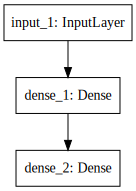

In [9]:
spectra_autoencoder = keras.models.load_model('../models/spectra_autoencoder_gnps_massbank.h5')
spectra_encoder = keras.models.load_model('../models/spectra_encoder_gnps_massbank.h5')
spectra_decoder = keras.models.load_model('../models/spectra_decoder_gnps_massbank.h5')
spectra_autoencoder.summary()
svg = plot_model_in_notebook(spectra_autoencoder)
svg

In [10]:
spectra_latent = spectra_encoder.predict(data['spectra'])
print(spectra_latent.shape)

(7901, 100)


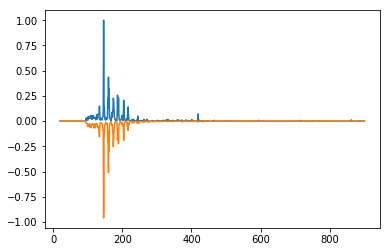

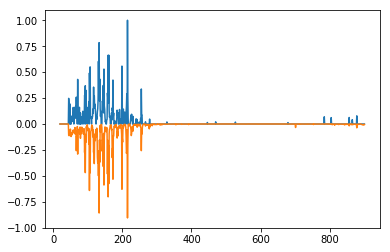

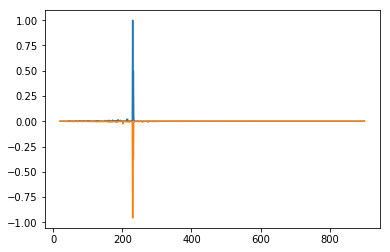

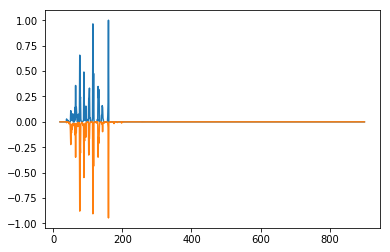

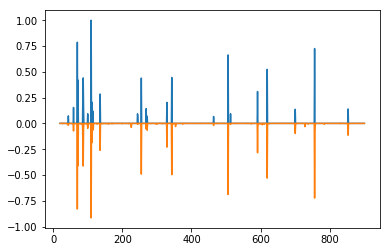

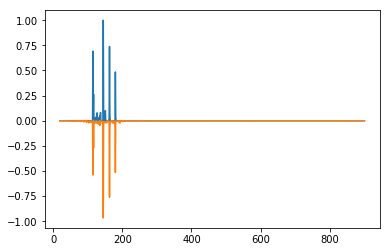

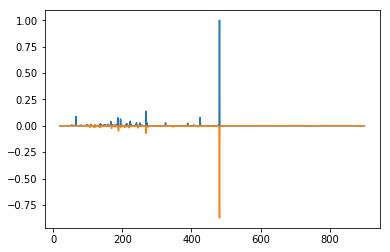

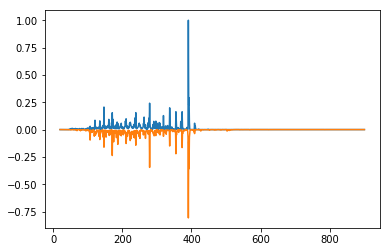

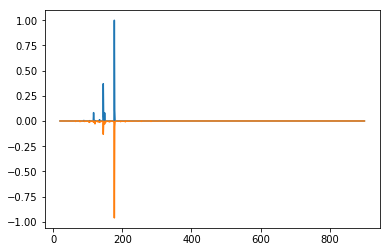

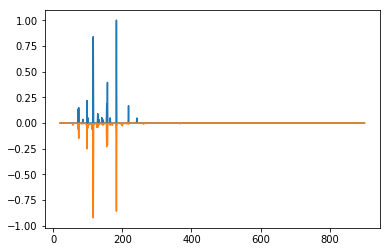

In [11]:
spectra_decoded = spectra_decoder.predict(spectra_latent)
for idx in range(10):
    pos = np.nonzero(data['spectra'][idx])
#     print(data['vocab'][pos])
    plt.plot(data['vocab'], data['spectra'][idx])
    plt.plot(data['vocab'], -spectra_decoded[idx])
    plt.show()

### Create Topological Fingerprints of Molecules

http://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity

The fingerprinting algorithm used is similar to that used in the Daylight fingerprinter: it identifies and hashes topological paths (e.g. along bonds) in the molecule and then uses them to set bits in a fingerprint of user-specified lengths. After all paths have been identified, the fingerprint is typically folded down until a particular density of set bits is obtained.

In [12]:
from rdkit.Chem.Fingerprints import FingerprintMols

In [13]:
def smiles_to_fingerprints(smiles):
    max_length = 0
    valid_idx = []
    fingerprints = []
    for i in range(len(smiles)):
        smile = smiles[i]
        mol = Chem.MolFromSmiles(smile)
        try:
            fp = FingerprintMols.FingerprintMol(mol)
            bits = np.array(list(fp.GetOnBits()))
            if max(bits) > max_length:
                max_length = max(bits)
            valid_idx.append(i)
            fingerprints.append(bits)
        except Exception:
            print('Invalid smile', smiles[i])
            continue

    fingerprint_arr = np.zeros((len(fingerprints), max_length+1))
    for i in range(len(fingerprints)):
        fingerprint = fingerprints[i]
        for bit in fingerprint:
            fingerprint_arr[i][bit] = 1

    return fingerprint_arr, valid_idx

In [14]:
fingerprint_arr, valid_idx = smiles_to_fingerprints(data['smiles'])
assert len(data['smiles']) == len(data['spectra'])
spectra = data['spectra'][valid_idx]
smiles = data['smiles'][valid_idx]

In [15]:
spectra_latent = spectra_encoder.predict(spectra)

In [16]:
fingerprint_arr.shape

(7901, 2048)

In [17]:
fingerprint_arr[0]

array([1., 1., 0., ..., 1., 0., 1.])

### Try joint embedding

Objective: build a model that projects spectra and molecules in the same representation space, so that a spectra is close to its molecule in that space, and far away from dissimilar spectra and dissimilar molecules.

Each training point is a triplet of:
- fragmentation spectra, also called an anchor
- compound correctly associated to that spectra, also called the positive example
- compound incorrectly associated to that spectra, also called the negative example

During training, we compute the scores of the anchor to the positive and negative examples (dot products). The optimisation objective is to maximise total positive scores and minimise total negative scores. Then for each training step, we shuffle the negative examples randomly.

See:

- https://pageperso.lis-lab.fr/benoit.favre/dl4nlp/tutorials/05-caption.pdf
- https://arxiv.org/abs/1511.06078

In [18]:
def get_embedding_model(input_dim_spectra, input_dim_molecule, embedding_dim):
    
    spectra_input = Input(shape=(input_dim_spectra,), name='spectra_input')
    smile_input = Input(shape=(input_dim_molecule,), name='positive_molecule')
    noise_input = Input(shape=(input_dim_molecule,), name='negative_molecule')
        
    spectra_pipeline = Dense(embedding_dim, use_bias=False, name='spectra_weights')(spectra_input)
    spectra_pipeline = BatchNormalization(name='bn1')(spectra_pipeline)
    spectra_pipeline = Activation('relu', name='relu1')(spectra_pipeline)
    spectra_pipeline = Dense(embedding_dim, activation='relu', name='spectra_weights2')(spectra_pipeline)

    smile_dense1 = Dense(embedding_dim, use_bias=False, name='molecule_weights') 
    bn = BatchNormalization(name='bn2')
    activation = Activation('relu', name='relu2')
    smile_dense2 = Dense(embedding_dim, activation='relu', name='molecule_weights2')
    smile_pipeline = smile_dense2(activation(bn(smile_dense1(smile_input))))
    noise_pipeline = smile_dense2(activation(bn(smile_dense1(noise_input))))        

    positive_pair = merge([spectra_pipeline, smile_pipeline], mode='dot', name='dot1')
    negative_pair = merge([spectra_pipeline, noise_pipeline], mode='dot', name='dot2')
    concat_output = merge([positive_pair, negative_pair], mode='concat', name='concat')
    embedding_model = Model(input=[spectra_input, smile_input, noise_input], output=concat_output)

    l2_norm = Lambda(lambda  x: K.l2_normalize(x, axis=1))    
    spectra_encoder = Model(input=spectra_input, output=l2_norm(spectra_pipeline))
    smile_encoder = Model(input=smile_input, output=l2_norm(smile_pipeline))
    
    # also see https://github.com/keras-team/keras/issues/150
    def custom_loss(y_true, y_pred):
        positive = y_pred[:,0]
        negative = y_pred[:,1]
        return K.sum(K.maximum(0., 1. - positive + negative))
    
    def accuracy(y_true, y_pred):
        positive = y_pred[:,0]
        negative = y_pred[:,1]
        return K.mean(positive > negative)
    
    embedding_model.compile(loss=custom_loss, optimizer='adam', metrics=[accuracy])
    return embedding_model, spectra_encoder, smile_encoder

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
spectra_input (InputLayer)      (None, 100)          0                                            
__________________________________________________________________________________________________
positive_molecule (InputLayer)  (None, 2048)         0                                            
__________________________________________________________________________________________________
negative_molecule (InputLayer)  (None, 2048)         0                                            
__________________________________________________________________________________________________
spectra_weights (Dense)         (None, 50)           5000        spectra_input[0][0]              
__________________________________________________________________________________________________
molecule_w

/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:21: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `k

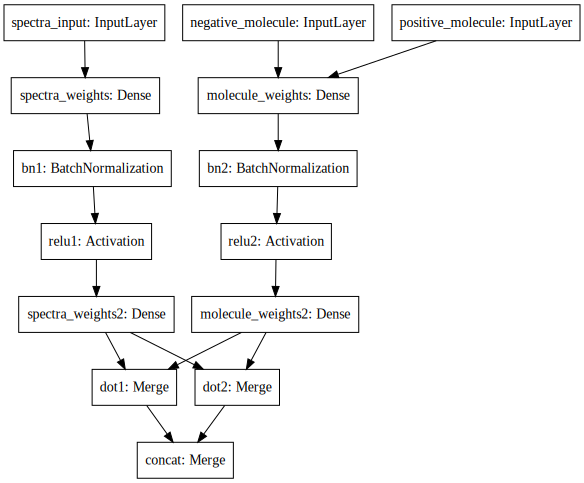

In [19]:
EMBEDDING_DIM = 50
input_dim_spectra = spectra_latent.shape[1]
input_dim_molecule = fingerprint_arr.shape[1]
joint_embedding_model, spectra_encoder, smile_encoder = get_embedding_model(input_dim_spectra, 
                                                                            input_dim_molecule, 
                                                                            EMBEDDING_DIM)
joint_embedding_model.summary()
plot_model_in_notebook(joint_embedding_model)

Preparing training and test data

In [20]:
def shuffle_together(a, b, c, d):
    assert len(a) == len(b)
    assert len(a) == len(c)
    assert len(a) == len(d)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p], d[p]

spectra, spectra_latent, smiles, fingerprint_arr = shuffle_together(spectra, spectra_latent, smiles, fingerprint_arr)
fingerprint_arr = StandardScaler().fit_transform(fingerprint_arr)
spectra_latent = StandardScaler().fit_transform(spectra_latent)

In [21]:
pos = int(len(spectra_latent) * 0.8)
remaining = len(spectra_latent) - pos
print(pos, remaining)

noise = np.copy(fingerprint_arr)
fake_labels = np.zeros((len(spectra_latent), 1))

X_train = [spectra_latent[:pos], fingerprint_arr[:pos], noise[:pos]]
Y_train = fake_labels[:pos]
X_test = [spectra_latent[-remaining:], fingerprint_arr[-remaining:], noise[-remaining:]]
Y_test = fake_labels[-remaining:]

spectra_train = spectra[:pos]
spectra_test = spectra[-remaining:]
smiles_train = smiles[:pos]
smiles_test = smiles[-remaining:]

6320 1581


In [22]:
print(X_train[0].shape, X_train[1].shape, X_train[2].shape)
print(X_test[0].shape, X_test[1].shape, X_test[2].shape)

(6320, 100) (6320, 2048) (6320, 2048)
(1581, 100) (1581, 2048) (1581, 2048)


In [23]:
# rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001,
#                         verbose=1, epsilon=1e-5)
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
# callbacks = [rlr, early_stop]

# tensorboard = keras.callbacks.TensorBoard(log_dir='./graph', histogram_freq=0,  
#           write_graph=True, write_images=True)
# callbacks = [rlr, early_stop, tensorboard]
# if is_notebook():
#     callbacks.append(PlotLossesKeras())

TODO: generate mini-batch properly https://stackoverflow.com/questions/48568062/keras-custom-infinite-data-generator-with-shuffle

In [24]:
# actual training
for epoch in range(1000):
    if epoch % 100 == 0:
        print('\nIteration %d' % epoch)
        verbose=1
    else:
        verbose=0
    np.random.shuffle(noise) # shuffle mismatched smiles
    joint_embedding_model.fit(X_train, Y_train,
        validation_data=[X_test, Y_test], epochs=1,
        batch_size=32, verbose=verbose)


Iteration 0
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 2s 316us/step - loss: 27.3706 - accuracy: 0.6278 - val_loss: 20.4116 - val_accuracy: 0.7141

Iteration 100
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 1s 164us/step - loss: 1.4072 - accuracy: 0.9828 - val_loss: 10.6046 - val_accuracy: 0.8899

Iteration 200
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 1s 174us/step - loss: 0.9980 - accuracy: 0.9877 - val_loss: 10.2452 - val_accuracy: 0.9102

Iteration 300
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 1s 165us/step - loss: 0.5233 - accuracy: 0.9922 - val_loss: 10.4509 - val_accuracy: 0.9058

Iteration 400
Train on 6320 samples, validate on 1581 samples
Epoch 1/1
6320/6320 [==============================] - 1s 161us/step - loss: 0.6728 - accuracy: 0.9916

In [25]:
joint_embedding_model.save('../models/joint_embedding_gnps_massbank.h5')
spectra_encoder.save('../models/joint_spectra_encoder_gnps_massbank.h5')
smile_encoder.save('../models/joint_smile_encoder_gnps_massbank.h5')

### Visualise the joint embedding results

In [29]:
def visualise_embedding(spectra_data, molecule_data, spectra_encoder, smile_encoder):
    
    embedded_spectra = spectra_encoder.predict(spectra_data)
    embedded_molecules = smile_encoder.predict(molecule_data)
    embedded_combined = np.concatenate([embedded_spectra, embedded_molecules], axis=0)
    
    PCA_COMPONENTS = 25
    pca = PCA(n_components = PCA_COMPONENTS)
    latent_proj = pca.fit_transform(embedded_combined)
    covariance = pca.get_covariance()
    evr = pca.explained_variance_ratio_
    print('Explained variations -- first two PCs: %.2f' % (evr[0] + evr[1]))
    print('Explained variations -- all components: %.2f' % np.sum(evr))
    print(evr)
        
    plt.figure(figsize=(8, 8))
    plt.scatter(latent_proj[0:len(embedded_spectra), 0], latent_proj[0:len(embedded_spectra), 1], marker='x', c='red', s=1)
    plt.scatter(latent_proj[len(embedded_spectra)+1:, 0], latent_proj[len(embedded_spectra)+1:, 1], marker='.', c='blue', s=1)
    plt.title('Joint embedding of fragmentation spectra (red) and molecules (blue)')

Visualise embedding on training data

Explained variations -- first two PCs: 0.19
Explained variations -- all components: 0.83
[0.10463472 0.08729892 0.05917596 0.05268223 0.04343165 0.04042976
 0.03749823 0.03328477 0.03081905 0.02993481 0.02845363 0.02762313
 0.02647934 0.02528371 0.02329797 0.02198844 0.02068576 0.01935718
 0.01873672 0.01783873 0.01756134 0.01597239 0.01550153 0.01535924
 0.01431741]


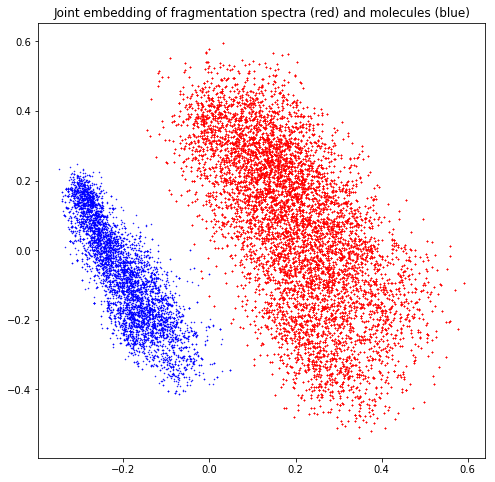

In [30]:
visualise_embedding(X_train[0], X_train[1], spectra_encoder, smile_encoder)

Visualise embedding on testing data

Explained variations -- first two PCs: 0.20
Explained variations -- all components: 0.83
[0.10669821 0.08913714 0.06025033 0.0539846  0.04440927 0.04255908
 0.03793784 0.03338074 0.03093512 0.03045025 0.02901372 0.02788227
 0.02516816 0.02473811 0.02366052 0.02275963 0.02097523 0.01863105
 0.01796724 0.01722828 0.01645531 0.01614627 0.01516461 0.01433366
 0.01343582]


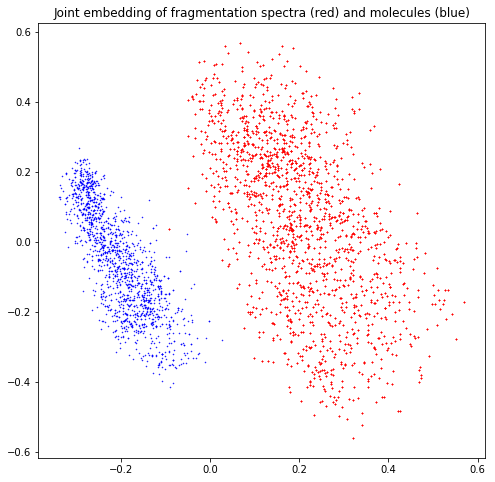

In [31]:
visualise_embedding(X_test[0], X_test[1], spectra_encoder, smile_encoder)

### Evaluation

In [32]:
embedded_spectra = spectra_encoder.predict(X_test[0])
embedded_molecules = smile_encoder.predict(X_test[1])

In [33]:
x = embedded_spectra[0]
print(x)
print(np.dot(x, x))

[0.1840117  0.         0.28230694 0.02828293 0.         0.02929746
 0.         0.         0.         0.02807022 0.         0.
 0.23002549 0.         0.20729807 0.         0.07018433 0.
 0.         0.00560902 0.43178213 0.         0.20574418 0.28399867
 0.         0.         0.         0.09466015 0.         0.
 0.6108876  0.         0.05494618 0.15487951 0.20147315 0.
 0.         0.         0.         0.         0.         0.
 0.02493951 0.15286867 0.         0.         0.         0.
 0.         0.        ]
1.0000001


In [34]:
plt.rcParams['figure.figsize'] = (8,8)

(1581, 1581)


Text(0.5,1.05,'Dot product')

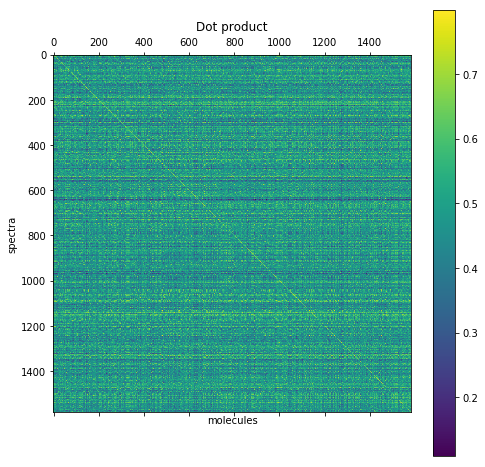

In [35]:
scores = np.dot(embedded_spectra, embedded_molecules.T)
print(scores.shape)
plt.matshow(scores)
plt.colorbar()
plt.xlabel('molecules')
plt.ylabel('spectra')
plt.title('Dot product')

In [60]:
def recall_at(n, scores, verbose=False):
    found = 0.0
    total = len(scores)
    results = {}
    for i in range(total):
        row = scores[i]
        max_idx = row.argsort()[-n:][::-1]
        if i in max_idx:
            found += 1
            correct = True
        else:
            correct = False
        retrieved = list(zip(max_idx, row[max_idx]))
        if verbose:
            print(i, correct, retrieved)
        results[i] = retrieved
    precision = found/total
    return precision, found, total, results

In [61]:
prec, found, total, results = recall_at(10, scores)

In [38]:
# decoy_smiles

In [39]:
print('Found %d/%d (%.2f)' % (found, total, prec))

Found 721/1581 (0.46)


In [40]:
def plot_spectra_and_molecule(idx, spectra, smiles):    
    pos = np.nonzero(spectra[idx])
    plt.plot(data['vocab'], spectra[idx])
    plt.show()
    smile = smiles[idx]    
    print(smile)
    mol = Chem.MolFromSmiles(smile)
    mol_drawing = Draw.MolToMPL(mol, size=(150, 150))
    plt.show()

In [ ]:
def plot_results(idx, spectra_test, smiles_test, results):
    plt.rcParams['figure.figsize'] = (4,4)
    
    print('Query')
    plot_spectra_and_molecule(idx, spectra_test, smiles_test)
    
    print("Retrieved")
    retrieved = results[idx]
    for j, score in retrieved:
        print('Molecule %d score %.2f' % (j, score))
        plot_spectra_and_molecule(j, spectra_test, smiles_test)

In [ ]:
plot_results(12, spectra_test, smiles_test, results)

Add decoy compounds

In [72]:
import pandas
import h5py
decoy_data = pandas.read_hdf('/Users/joewandy/Dropbox/Analysis/autoencoder/data/pubchem_100k.h5', 'table')
decoy_smiles = decoy_data['structure'].values

In [73]:
decoy_fingerprint_arr, valid_decoy_idx = smiles_to_fingerprints(decoy_smiles)

RDKit ERROR: [12:43:21] SMILES Parse Error: unclosed ring for input: 'COC1C=CC(C)C(C(C)C(OC)C(C)CCC(=O)C(C)C(CC=CN(C)C=O)OC)OC(=O)C=CC=C(C)CC(OC)CC2=C(O)C(OC(=O)C2)C(C)C(OC)CC(OC)C=CC(C)C(O)'


Invalid smile COC1C=CC(C)C(C(C)C(OC)C(C)CCC(=O)C(C)C(CC=CN(C)C=O)OC)OC(=O)C=CC=C(C)CC(OC)CC2=C(O)C(OC(=O)C2)C(C)C(OC)CC(OC)C=CC(C)C(O)
Invalid smile [Cr].[Na+].[Na+].[O-].[O-].[O].[O]
Invalid smile [Sm]
Invalid smile Br


RDKit ERROR: [12:43:31] SMILES Parse Error: syntax error for input: 'C[PH+](C)[PH+](C)C.[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].['
RDKit ERROR: [12:43:31] SMILES Parse Error: unclosed ring for input: 'CN(C)c1cc(C(C)(C)C)cc2c1-c1nc3nc(nc4[n-]c([n-]c5nc(nc-2n1)-c1c-5cc(C(C)(C)C)cc1N(C)C)c1c(N(C)C)cc(C(C)(C)C)cc41)-c1c-3cc'


Invalid smile C[PH+](C)[PH+](C)C.[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[C-]#[O+].[
Invalid smile CN(C)c1cc(C(C)(C)C)cc2c1-c1nc3nc(nc4[n-]c([n-]c5nc(nc-2n1)-c1c-5cc(C(C)(C)C)cc1N(C)C)c1c(N(C)C)cc(C(C)(C)C)cc41)-c1c-3cc
Invalid smile [O].[O].[Os+2]
Invalid smile O.O.O.O.O.[Cd]
Invalid smile [Se-2].[Se-2].[Se-2].[Y+3].[Y+3]


RDKit ERROR: [12:43:37] SMILES Parse Error: extra open parentheses for input: 'CCCC(N=C(O)C(N=C(O)C(N=C(O)C(N=C(O)C(CCC(=N)O)N=C(C)O)C(C)C)C(C)CC)C(C)O)C(O)=NC(C(O)=NC(CCCNC(=N)N)C(=O)N1CCCC1C(O)=NCC'


Invalid smile CCCC(N=C(O)C(N=C(O)C(N=C(O)C(N=C(O)C(CCC(=N)O)N=C(C)O)C(C)C)C(C)CC)C(C)O)C(O)=NC(C(O)=NC(CCCNC(=N)N)C(=O)N1CCCC1C(O)=NCC
Invalid smile [Ga]


RDKit ERROR: [12:43:39] SMILES Parse Error: extra open parentheses for input: 'CCCC(N=C(O)C(N=C(O)C(N=C(O)C(N=C(O)CNCc1ccc(C)nc1)C(C)C)C(C)CC)C(C)O)C(O)=NC(C(O)=NC(CCCNC(=N)N)C(=O)N1CCCC1C(O)=NCC)C(C'


Invalid smile CCCC(N=C(O)C(N=C(O)C(N=C(O)C(N=C(O)CNCc1ccc(C)nc1)C(C)C)C(C)CC)C(C)O)C(O)=NC(C(O)=NC(CCCNC(=N)N)C(=O)N1CCCC1C(O)=NCC)C(C


RDKit ERROR: [12:43:39] SMILES Parse Error: unclosed ring for input: 'CCN(CCCN(CC=CCN(CCCN(CC)S(=O)(=O)c1c(C)cc(C)cc1C)S(=O)(=O)c1c(C)cc(C)cc1C)S(=O)(=O)c1c(C)cc(C)cc1C)S(=O)(=O)c1c(C)cc(C)c'


Invalid smile [Be].[S]
Invalid smile CCN(CCCN(CC=CCN(CCCN(CC)S(=O)(=O)c1c(C)cc(C)cc1C)S(=O)(=O)c1c(C)cc(C)cc1C)S(=O)(=O)c1c(C)cc(C)cc1C)S(=O)(=O)c1c(C)cc(C)c
Invalid smile [Bi+3].[F-].[F-].[F-]


RDKit ERROR: [12:43:42] SMILES Parse Error: extra open parentheses for input: 'Nc1c(N=Nc2ccc(C(O)=Nc3ccc(NN=C4C=CC(NCC(=O)O)=CC4=O)cc3)cc2)c(S(=O)(=O)O)cc2c1C(=O)C(=NNc1ccc(S(=O)(=O)O)cc1)C(S(=O)(=O)'


Invalid smile Nc1c(N=Nc2ccc(C(O)=Nc3ccc(NN=C4C=CC(NCC(=O)O)=CC4=O)cc3)cc2)c(S(=O)(=O)O)cc2c1C(=O)C(=NNc1ccc(S(=O)(=O)O)cc1)C(S(=O)(=O)


RDKit ERROR: [12:43:45] SMILES Parse Error: syntax error for input: 'COc1cc(O)cc(OC)c1C1C2=CCC3C(=O)N(c4cc([N+](=O)[O-])c(N(C)C)c([N+](=O)[O-])c4)C(=O)C3C2CC2C(=O)N(Nc3ncc(C(F)(F)F)cc3Cl)C('


Invalid smile COc1cc(O)cc(OC)c1C1C2=CCC3C(=O)N(c4cc([N+](=O)[O-])c(N(C)C)c([N+](=O)[O-])c4)C(=O)C3C2CC2C(=O)N(Nc3ncc(C(F)(F)F)cc3Cl)C(
Invalid smile [O-2].[O-2].[O-2].[Ti+3].[Ti+3]


RDKit ERROR: [12:43:49] SMILES Parse Error: syntax error for input: 'C=CC(=O)N1C(C)(C)CC(OC(=O)C(Cc2cc(C(C)(C)C)c(O)c(C(C)(C)C)c2)(Cc2cc(C(C)(C)C)c(O)c(C(C)(C)C)c2)C(=O)OC2CC(C)(C)N(C(=O)C='


Invalid smile C=CC(=O)N1C(C)(C)CC(OC(=O)C(Cc2cc(C(C)(C)C)c(O)c(C(C)(C)C)c2)(Cc2cc(C(C)(C)C)c(O)c(C(C)(C)C)c2)C(=O)OC2CC(C)(C)N(C(=O)C=
Invalid smile [F-].[F-].[F-].[Ga+3]


RDKit ERROR: [12:43:54] SMILES Parse Error: syntax error for input: 'CC(=O)[C-](C)C(C)=O.CC(=O)[C-](C)C(C)=O.COc1cc2c(c(OC)c1OC)=NC(=C([O-])N1CC(CCl)c3ccc([N-]CC[NH-])cc31)C=2.[Co+3].[O-][C'


Invalid smile CC(=O)[C-](C)C(C)=O.CC(=O)[C-](C)C(C)=O.COc1cc2c(c(OC)c1OC)=NC(=C([O-])N1CC(CCl)c3ccc([N-]CC[NH-])cc31)C=2.[Co+3].[O-][C
Invalid smile [Ga].[H].[H]


RDKit ERROR: [12:44:01] SMILES Parse Error: syntax error for input: 'CCCC(N=C(O)C(N=C(O)C(N=C(O)C(Cc1ccccc1)N(C)C(=O)CN=C(C)O)C(C)CC)C(C)O)C(O)=NC(C(O)=NC(CCCNC(=N)N)C(=O)N1CCCC1C(O)=NCC)C('


Invalid smile CCCC(N=C(O)C(N=C(O)C(N=C(O)C(Cc1ccccc1)N(C)C(=O)CN=C(C)O)C(C)CC)C(C)O)C(O)=NC(C(O)=NC(CCCNC(=N)N)C(=O)N1CCCC1C(O)=NCC)C(


RDKit ERROR: [12:44:02] SMILES Parse Error: syntax error for input: 'C=CCc1cccc(C2C3=CCC4C(=O)N(c5cc([N+](=O)[O-])c(N(C)C)c([N+](=O)[O-])c5)C(=O)C4C3CC3C(=O)N(c4cc([N+](=O)[O-])c(N(C)C)c([N'


Invalid smile C=CCc1cccc(C2C3=CCC4C(=O)N(c5cc([N+](=O)[O-])c(N(C)C)c([N+](=O)[O-])c5)C(=O)C4C3CC3C(=O)N(c4cc([N+](=O)[O-])c(N(C)C)c([N


RDKit ERROR: [12:44:04] SMILES Parse Error: unclosed ring for input: 'CCCC[n+]1cccc2cc(NC(=O)c3ccc(-c4ccc(C(=O)Nc5ccc6c(ccc[n+]6CCCC)c5)cc4)cc3)ccc21.Cc1ccc(S(=O)(=O)O)cc1.Cc1ccc(S(=O)(=O)O)'


Invalid smile CCCC[n+]1cccc2cc(NC(=O)c3ccc(-c4ccc(C(=O)Nc5ccc6c(ccc[n+]6CCCC)c5)cc4)cc3)ccc21.Cc1ccc(S(=O)(=O)O)cc1.Cc1ccc(S(=O)(=O)O)
Invalid smile Cl.[O].[Sb]


RDKit ERROR: [12:44:05] SMILES Parse Error: unclosed ring for input: 'CC[Si](CC)(CC)OC1CC(O[Si](C)(C)C)C23OC2C([Si](C)(C)c2ccccc2)C(C)C(CCC2CC(CCO[Si](c4ccccc4)(c4ccccc4)C(C)(C)C)OC(C)(C)O2)'
RDKit ERROR: [12:44:05] SMILES Parse Error: unclosed ring for input: 'C=CCOC12Oc3ccc(Oc4ccc(C)c(C)c4)cc3C3C(CCCCO)C(CCCCO)C=C(C(=NOCc4ccc([N+](=O)[O-])cc4)CC1N(Cc1ccc4c(c1)OCO4)C(=O)OCCCl)C3'


Invalid smile CC[Si](CC)(CC)OC1CC(O[Si](C)(C)C)C23OC2C([Si](C)(C)c2ccccc2)C(C)C(CCC2CC(CCO[Si](c4ccccc4)(c4ccccc4)C(C)(C)C)OC(C)(C)O2)
Invalid smile C=CCOC12Oc3ccc(Oc4ccc(C)c(C)c4)cc3C3C(CCCCO)C(CCCCO)C=C(C(=NOCc4ccc([N+](=O)[O-])cc4)CC1N(Cc1ccc4c(c1)OCO4)C(=O)OCCCl)C3
Invalid smile [As]


RDKit ERROR: [12:44:06] SMILES Parse Error: extra open parentheses for input: 'CC1OC(=O)CN(C)C(=O)C(Cc2ccc(N3CCOCC3)cc2)OC(=O)C(C(C)C)C(C)N=C(O)C(C)OC(=O)CN(C)C(=O)C(Cc2ccc(N3CCOCC3)cc2)OC(=O)C(C(C)C'


Invalid smile CC1OC(=O)CN(C)C(=O)C(Cc2ccc(N3CCOCC3)cc2)OC(=O)C(C(C)C)C(C)N=C(O)C(C)OC(=O)CN(C)C(=O)C(Cc2ccc(N3CCOCC3)cc2)OC(=O)C(C(C)C
Invalid smile [Li+].[Ni].[O-].[O]


RDKit ERROR: [12:44:14] SMILES Parse Error: unclosed ring for input: 'CCC1OC(=O)C(C)C(OC(=O)Cc2ccccn2)C(C)C(OC2OC(C)CC(N(C)C)C2O)C(C)(OC)CC(C)C(=O)C(C)C2N(CCNS(=O)(=O)c3ccc([N+](=O)[O-])cc3)'


Invalid smile CCC1OC(=O)C(C)C(OC(=O)Cc2ccccn2)C(C)C(OC2OC(C)CC(N(C)C)C2O)C(C)(OC)CC(C)C(=O)C(C)C2N(CCNS(=O)(=O)c3ccc([N+](=O)[O-])cc3)


RDKit ERROR: [12:44:17] SMILES Parse Error: extra open parentheses for input: 'CSCCC(N=C(O)C(C)(C)N)C(O)=NC(Cc1ccc(O)cc1)C(=O)N1CCCC1C(O)=NC(C(O)=NC(Cc1ccc(O)cc1)C(O)=NC(C)(C)C(O)=NC(CCCCN)C(=O)O)C(C'


Invalid smile CSCCC(N=C(O)C(C)(C)N)C(O)=NC(Cc1ccc(O)cc1)C(=O)N1CCCC1C(O)=NC(C(O)=NC(Cc1ccc(O)cc1)C(O)=NC(C)(C)C(O)=NC(CCCCN)C(=O)O)C(C


RDKit ERROR: [12:44:18] SMILES Parse Error: extra open parentheses for input: 'O=S(=O)(O)c1cc2[nH]c1c(-c1c(F)c(F)c(F)c(F)c1F)c1nc(c(-c3c(F)c(F)c(F)c(F)c3F)c3ccc([nH]3)c(-c3c(F)c(F)c(F)c(F)c3F)c3[nH]c'


Invalid smile O=S(=O)(O)c1cc2[nH]c1c(-c1c(F)c(F)c(F)c(F)c1F)c1nc(c(-c3c(F)c(F)c(F)c(F)c3F)c3ccc([nH]3)c(-c3c(F)c(F)c(F)c(F)c3F)c3[nH]c


RDKit ERROR: [12:44:19] SMILES Parse Error: syntax error for input: 'CCN(CC)CC.CCN(CC)CC.[H]C([H])([H])C(O)=NC1C(OP(=O)(O)O)OC(COC(C)=O)C(OC(C)=O)C1OC1OC(COC(C)=O)C(OC(C)=O)C(OC(C)=O)C1N=C('


Invalid smile CCN(CC)CC.CCN(CC)CC.[H]C([H])([H])C(O)=NC1C(OP(=O)(O)O)OC(COC(C)=O)C(OC(C)=O)C1OC1OC(COC(C)=O)C(OC(C)=O)C(OC(C)=O)C1N=C(


RDKit ERROR: [12:44:20] SMILES Parse Error: syntax error for input: 'CS(=O)(=O)c1ccc2c(c1)C(NCCN)Cc1ccccc1S2.O=[N+]([O-])c1cc([N+](=O)[O-])c(O)c([N+](=O)[O-])c1.O=[N+]([O-])c1cc([N+](=O)[O-'


Invalid smile CS(=O)(=O)c1ccc2c(c1)C(NCCN)Cc1ccccc1S2.O=[N+]([O-])c1cc([N+](=O)[O-])c(O)c([N+](=O)[O-])c1.O=[N+]([O-])c1cc([N+](=O)[O-


RDKit ERROR: [12:44:27] SMILES Parse Error: extra open parentheses for input: 'C=CCOc1nc(=NC2c3c(cc4ccc5cccc6ccc3c4c56)C(OC(C)=O)C(OC(C)=O)C2OC(C)=O)[nH]c2c1ncn2C1CC(O[Si](C)(C)C(C)(C)C)C(CO[Si](C)(C'


Invalid smile C=CCOc1nc(=NC2c3c(cc4ccc5cccc6ccc3c4c56)C(OC(C)=O)C(OC(C)=O)C2OC(C)=O)[nH]c2c1ncn2C1CC(O[Si](C)(C)C(C)(C)C)C(CO[Si](C)(C


RDKit ERROR: [12:44:27] SMILES Parse Error: unclosed ring for input: 'N=C(O)NCC#Cc1ccc2c(c1)C1(C(=O)N2C(=O)OCc2ccc([N+](=O)[O-])cc2)C(C(=O)N2CCN(c3ncccn3)CC2)C2C(=O)OC(c3ccccc3)C(c3ccccc3)N2'
RDKit ERROR: [12:44:27] SMILES Parse Error: unclosed ring for input: 'COc1ccc(C#Cc2ccc3c(c2)C2(C(=O)N3C(=O)OCc3ccc([N+](=O)[O-])cc3)C(C(=O)O)C3C(=O)OC(c4ccccc4)C(c4ccccc4)N3C2c2ccc(OCCO)cc2)'


Invalid smile N=C(O)NCC#Cc1ccc2c(c1)C1(C(=O)N2C(=O)OCc2ccc([N+](=O)[O-])cc2)C(C(=O)N2CCN(c3ncccn3)CC2)C2C(=O)OC(c3ccccc3)C(c3ccccc3)N2
Invalid smile COc1ccc(C#Cc2ccc3c(c2)C2(C(=O)N3C(=O)OCc3ccc([N+](=O)[O-])cc3)C(C(=O)O)C3C(=O)OC(c4ccccc4)C(c4ccccc4)N3C2c2ccc(OCCO)cc2)
Invalid smile [V+4]
Invalid smile [Sm]


RDKit ERROR: [12:44:35] SMILES Parse Error: syntax error for input: 'COCCOC(=O)N1C(=O)C2(c3cc(C#CCC(C(=O)OC)C(=O)OC)ccc31)C(C(=O)Nc1ccc(N3CCOCC3)cc1)C1C(=O)OC(c3ccccc3)C(c3ccccc3)N1C2c1ccc('


Invalid smile COCCOC(=O)N1C(=O)C2(c3cc(C#CCC(C(=O)OC)C(=O)OC)ccc31)C(C(=O)Nc1ccc(N3CCOCC3)cc1)C1C(=O)OC(c3ccccc3)C(c3ccccc3)N1C2c1ccc(


RDKit ERROR: [12:44:37] SMILES Parse Error: extra open parentheses for input: 'CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(OC(=O)OCc3ccccc3)C(C)O2)C(C)C(OC2OC(C)CC([N+](C)(C)[O-])C2OC(C)=O)C(C)(O)CC(C)C(O)C(C)C(=O'


Invalid smile CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(OC(=O)OCc3ccccc3)C(C)O2)C(C)C(OC2OC(C)CC([N+](C)(C)[O-])C2OC(C)=O)C(C)(O)CC(C)C(O)C(C)C(=O
Invalid smile [Ag+].[F-].[F-].[F-].[F-].[F-].[F-].[Sb]
Invalid smile [P].[Tb]
Invalid smile [Mo].[NH]


RDKit ERROR: [12:44:42] SMILES Parse Error: unclosed ring for input: 'CC1=NN(c2ccccc2)C(=O)C1NNc1cc(S(=O)(=O)[O-])cc2c1C(=O)C(=NN=C1C=C(S(=O)(=O)[O-])C=C([N+](=O)[O-])C1=O)C(S(=O)(=O)[O-])=C'


Invalid smile CC1=NN(c2ccccc2)C(=O)C1NNc1cc(S(=O)(=O)[O-])cc2c1C(=O)C(=NN=C1C=C(S(=O)(=O)[O-])C=C([N+](=O)[O-])C1=O)C(S(=O)(=O)[O-])=C


RDKit ERROR: [12:44:42] SMILES Parse Error: unclosed ring for input: 'CC(=O)[CH-]C(=O)c1ccccc1.CC(=O)[CH-]C(=O)c1ccccc1.CC12CCC(=O)C=C1CCC1C2CCC2(C)C([O-])CCC12.CC12CCC(=O)C=C1CCC1C2CCC2(C)C'


Invalid smile CC(=O)[CH-]C(=O)c1ccccc1.CC(=O)[CH-]C(=O)c1ccccc1.CC12CCC(=O)C=C1CCC1C2CCC2(C)C([O-])CCC12.CC12CCC(=O)C=C1CCC1C2CCC2(C)C


RDKit ERROR: [12:44:43] SMILES Parse Error: extra open parentheses for input: 'COC(=O)CCC1=C(CC(=O)OC)C2(Cc3[nH]c(c(CC(=O)OC)c3CCC(=O)OC)Cc3[nH]c(c(CC(=O)OC)c3CCC(=O)OC)Cc3[nH]c(c(CC(=O)OC)c3CCC(=O)O'


Invalid smile COC(=O)CCC1=C(CC(=O)OC)C2(Cc3[nH]c(c(CC(=O)OC)c3CCC(=O)OC)Cc3[nH]c(c(CC(=O)OC)c3CCC(=O)OC)Cc3[nH]c(c(CC(=O)OC)c3CCC(=O)O


RDKit ERROR: [12:44:43] SMILES Parse Error: extra open parentheses for input: 'CCC(C)C(N=C(O)C(Cc1ccccc1)N=C(O)C(N=C(O)C(N=C(O)C(N=C(O)C(N)CCCCN)C(C)C)C(C)CC)C(C)O)C(O)=NC(CC(=O)O)C(O)=NC(CC(C)C)C(=O'


Invalid smile CCC(C)C(N=C(O)C(Cc1ccccc1)N=C(O)C(N=C(O)C(N=C(O)C(N=C(O)C(N)CCCCN)C(C)C)C(C)CC)C(C)O)C(O)=NC(CC(=O)O)C(O)=NC(CC(C)C)C(=O


RDKit ERROR: [12:44:44] SMILES Parse Error: unclosed ring for input: 'COC1C=COC2(C)Oc3c(C)c(O)c4c(O)c(cc(O)c4c3C2=O)N(C(=N)N2CCN(CC=Cc3ccccc3)CC2)C(=O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(OC(C)=O)'
RDKit ERROR: [12:44:45] SMILES Parse Error: unclosed ring for input: 'C=CCOC12Oc3ccc(OCCN4CC4)cc3C3C(CCCCO)C(CCCCO)C=C(C(=NOCc4ccc([N+](=O)[O-])cc4)CC1N(CCC)C(=O)C=Cc1ccc([N+](=O)[O-])cc1)C3'


Invalid smile COC1C=COC2(C)Oc3c(C)c(O)c4c(O)c(cc(O)c4c3C2=O)N(C(=N)N2CCN(CC=Cc3ccccc3)CC2)C(=O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(OC(C)=O)
Invalid smile C=CCOC12Oc3ccc(OCCN4CC4)cc3C3C(CCCCO)C(CCCCO)C=C(C(=NOCc4ccc([N+](=O)[O-])cc4)CC1N(CCC)C(=O)C=Cc1ccc([N+](=O)[O-])cc1)C3


RDKit ERROR: [12:44:47] SMILES Parse Error: extra open parentheses for input: 'COC1C=COC2(C)Oc3c(C)c(O)c4c(c3C2=O)C(=O)C(=CNN2C(C)CN(Cc3ccc([N+](=O)[O-])cc3)CC2C)C(=C4O)N=C(O)C(C)=CC=CC(C)C(O)C(C)C(O'


Invalid smile COC1C=COC2(C)Oc3c(C)c(O)c4c(c3C2=O)C(=O)C(=CNN2C(C)CN(Cc3ccc([N+](=O)[O-])cc3)CC2C)C(=C4O)N=C(O)C(C)=CC=CC(C)C(O)C(C)C(O
Invalid smile [Li+].[Li+].[Mo].[SH-].[SH-].[S]
Invalid smile [Co+].[I-]


RDKit ERROR: [12:44:54] SMILES Parse Error: unclosed ring for input: 'Cc1ccc(S(=O)(=O)NC(Cc2ccccc2)C(O)=NCc2cccc(-c3ccc(C4OC(CN5CCN(c6ccc([N+](=O)[O-])cc6)CC5)C(C)C(c5ccc(CO)cc5)O4)cc3)c2)cc'


Invalid smile Cc1ccc(S(=O)(=O)NC(Cc2ccccc2)C(O)=NCc2cccc(-c3ccc(C4OC(CN5CCN(c6ccc([N+](=O)[O-])cc6)CC5)C(C)C(c5ccc(CO)cc5)O4)cc3)c2)cc


RDKit ERROR: [12:44:56] SMILES Parse Error: syntax error for input: 'COc1c(N=Nc2ccc(N=Nc3c(S(=O)(=O)[O-])cc4cc(S(=O)(=O)[O-])cc(S(=O)(=O)[O-])c4c3[O-])c([O-])c2)cc(Nc2ccncn2)cc1S(=O)(=O)[O-'


Invalid smile COc1c(N=Nc2ccc(N=Nc3c(S(=O)(=O)[O-])cc4cc(S(=O)(=O)[O-])cc(S(=O)(=O)[O-])c4c3[O-])c([O-])c2)cc(Nc2ccncn2)cc1S(=O)(=O)[O-


RDKit ERROR: [12:44:57] SMILES Parse Error: unclosed ring for input: 'COc1ccc(Cn2c(=O)ccn(C3OC(C(O)C(NCCCN=C(O)C(N)C(O)C(C)C)C(=O)OC(C)(C)C)C(O[Si](C)(C)C(C)(C)C)C3O[Si](C)(C)C(C)(C)C)c2=O)c'


Invalid smile COc1ccc(Cn2c(=O)ccn(C3OC(C(O)C(NCCCN=C(O)C(N)C(O)C(C)C)C(=O)OC(C)(C)C)C(O[Si](C)(C)C(C)(C)C)C3O[Si](C)(C)C(C)(C)C)c2=O)c
Invalid smile [O-2].[O-2].[O-2].[W]


RDKit ERROR: [12:44:58] SMILES Parse Error: unclosed ring for input: 'COc1cc2nc(CCn3c(=O)n4n(c3=O)C3CC5C(=O)N(Nc6ncc(C(F)(F)F)cc6Cl)C(=O)C5(c5ccc(Cl)cc5)C(c5c(O)ccc6ccccc56)C3=CC4)c(=O)n(C)c'


Invalid smile COc1cc2nc(CCn3c(=O)n4n(c3=O)C3CC5C(=O)N(Nc6ncc(C(F)(F)F)cc6Cl)C(=O)C5(c5ccc(Cl)cc5)C(c5c(O)ccc6ccccc56)C3=CC4)c(=O)n(C)c
Invalid smile [Ga].[Ga].[H].[H].[H].[H].[Te]


RDKit ERROR: [12:45:01] SMILES Parse Error: extra open parentheses for input: 'CC(C=CC(C)(F)C(C)(C)O)C1CCC2C1(C)CCC1C23C=CC2(CC(O[Si](C)(C)C(C)(C)C)CC(O[Si](C)(C)C(C)(C)C)C12C)n1c(=O)n(-c2ccccc2)c(=O'


Invalid smile CC(C=CC(C)(F)C(C)(C)O)C1CCC2C1(C)CCC1C23C=CC2(CC(O[Si](C)(C)C(C)(C)C)CC(O[Si](C)(C)C(C)(C)C)C12C)n1c(=O)n(-c2ccccc2)c(=O


RDKit ERROR: [12:45:02] SMILES Parse Error: syntax error for input: 'N=C(N)SCCc1ccc(CCSC(=N)N)cc1.O=[N+]([O-])c1cc([N+](=O)[O-])c(O)c([N+](=O)[O-])c1.O=[N+]([O-])c1cc([N+](=O)[O-])c(O)c([N+'


Invalid smile N=C(N)SCCc1ccc(CCSC(=N)N)cc1.O=[N+]([O-])c1cc([N+](=O)[O-])c(O)c([N+](=O)[O-])c1.O=[N+]([O-])c1cc([N+](=O)[O-])c(O)c([N+


RDKit ERROR: [12:45:02] SMILES Parse Error: syntax error for input: 'N#Cc1c(-c2ccccc2)cc(-c2ccc(NS(=O)(=O)c3cccc(C(=O)c4cccc(S(=O)(=O)Nc5ccc(-c6cc(-c7ccccc7)c(C#N)c(=N)[nH]6)cc5)c4)c3)cc2)['


Invalid smile N#Cc1c(-c2ccccc2)cc(-c2ccc(NS(=O)(=O)c3cccc(C(=O)c4cccc(S(=O)(=O)Nc5ccc(-c6cc(-c7ccccc7)c(C#N)c(=N)[nH]6)cc5)c4)c3)cc2)[
Invalid smile [As].[As].[O-2].[O-2].[O-2].[Sb+3].[Sb+3]
Invalid smile [Cl-].[Cl-].[Cl-].[Eu+3]


RDKit ERROR: [12:45:07] SMILES Parse Error: syntax error for input: 'COc1ccc(C23C(=O)N(Nc4ccc(Cl)cc4Cl)C(=O)C2CC2C(=CCC4C(=O)N(c5cc([N+](=O)[O-])c(N(C)C)c([N+](=O)[O-])c5)C(=O)C42)C3c2cccc('


Invalid smile COc1ccc(C23C(=O)N(Nc4ccc(Cl)cc4Cl)C(=O)C2CC2C(=CCC4C(=O)N(c5cc([N+](=O)[O-])c(N(C)C)c([N+](=O)[O-])c5)C(=O)C42)C3c2cccc(


RDKit ERROR: [12:45:08] SMILES Parse Error: extra open parentheses for input: 'COC1C=COC2(C)Oc3c(C)c(O)c4c(c3C2=O)C(=O)C(N2CCN(c3cc(C)nc5ccccc35)CC2)=C(N=C(O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(OC(C)=O)C1'


Invalid smile COC1C=COC2(C)Oc3c(C)c(O)c4c(c3C2=O)C(=O)C(N2CCN(c3cc(C)nc5ccccc35)CC2)=C(N=C(O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(OC(C)=O)C1
Invalid smile [I-].[I-].[I-].[Na+].[Na+].[Na+]


RDKit ERROR: [12:45:12] SMILES Parse Error: unclosed ring for input: 'COC1C=COC2(C)Oc3c(C)c(O)c4c(c3C2=O)C(=O)C(=CNN2CCN(CCCc3ccccc3)CC2)C(=C4O)N=C(O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(OC(C)=O)C'


Invalid smile COC1C=COC2(C)Oc3c(C)c(O)c4c(c3C2=O)C(=O)C(=CNN2CCN(CCCc3ccccc3)CC2)C(=C4O)N=C(O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(OC(C)=O)C
Invalid smile [O-2].[OH-].[Zr+4]
Invalid smile I


RDKit ERROR: [12:45:18] SMILES Parse Error: extra open parentheses for input: 'COc1ccc(OC)c(C=Cc2ccc(N3C(=O)C4CC=C5C(CC6C(=O)N(Nc7ncc(C(F)(F)F)cc7Cl)C(=O)C6(c6ccc(Cl)cc6)C5c5cc(C)c(O)c(C)c5)C4C3=O)cc'


Invalid smile COc1ccc(OC)c(C=Cc2ccc(N3C(=O)C4CC=C5C(CC6C(=O)N(Nc7ncc(C(F)(F)F)cc7Cl)C(=O)C6(c6ccc(Cl)cc6)C5c5cc(C)c(O)c(C)c5)C4C3=O)cc
Invalid smile [F-].[F-].[Fe+2]
Invalid smile [Cl-].[Cl-].[Cl-].[O-2].[V]
Invalid smile O.O.O.O.O.O.[Ru+3]
Invalid smile Cc1cc2c(c(O)c1-c1c(C)cc3c(c1O)C(=CNc1c(C)n(C)n(-c4ccccc4)c1=O)C(=O)C(O)=C3C(C)C)C(=CNc1c(C)n(C)n(-c3ccccc3)c1=O)C(=O)C(O


RDKit ERROR: [12:45:22] SMILES Parse Error: extra open parentheses for input: 'Cc1cc2c(c(O)c1-c1c(C)cc3c(c1O)C(=CNc1c(C)n(C)n(-c4ccccc4)c1=O)C(=O)C(O)=C3C(C)C)C(=CNc1c(C)n(C)n(-c3ccccc3)c1=O)C(=O)C(O'
RDKit ERROR: [12:45:22] SMILES Parse Error: extra open parentheses for input: 'O=C(O)C=C(C(=O)OC1C2COC(=O)c3cc(O)c(O)c(O)c3-c3c(cc(O)c(O)c3O)C(=O)OC1C(O)C(OC(=O)c1cc(O)c(O)c(O)c1)C2)C1c2c(cc(O)c(O)c2'


Invalid smile O=C(O)C=C(C(=O)OC1C2COC(=O)c3cc(O)c(O)c(O)c3-c3c(cc(O)c(O)c3O)C(=O)OC1C(O)C(OC(=O)c1cc(O)c(O)c(O)c1)C2)C1c2c(cc(O)c(O)c2


RDKit ERROR: [12:45:24] SMILES Parse Error: extra open parentheses for input: 'COC(=O)C(N=C(O)N1C(=O)C2(c3cc(C#Cc4ccc(OC)cc4)ccc31)C(C(=O)N1CCN(c3ncccn3)CC1)C1C(=O)OC(c3ccccc3)C(c3ccccc3)N1C2c1ccc(O)'


Invalid smile COC(=O)C(N=C(O)N1C(=O)C2(c3cc(C#Cc4ccc(OC)cc4)ccc31)C(C(=O)N1CCN(c3ncccn3)CC1)C1C(=O)OC(c3ccccc3)C(c3ccccc3)N1C2c1ccc(O)


RDKit ERROR: [12:45:24] SMILES Parse Error: syntax error for input: 'CSCCC(N=C(O)C1CCCN1C(=O)C(CC(=O)O)N=C(O)C(N=C(O)C(C)N=C(O)C(CCC(=O)O)N=C(O)C(N=C(O)C1CCCN1C(=O)C(N)C(C)C)C(C)C)C(C)C)C(='


Invalid smile CSCCC(N=C(O)C1CCCN1C(=O)C(CC(=O)O)N=C(O)C(N=C(O)C(C)N=C(O)C(CCC(=O)O)N=C(O)C(N=C(O)C1CCCN1C(=O)C(N)C(C)C)C(C)C)C(C)C)C(=


RDKit ERROR: [12:45:30] SMILES Parse Error: syntax error for input: 'O=[N+]([O-])c1ccc(Nc2ccc(N=Nc3ccc(N=Nc4ccc(OS(=O)(=O)c5ccccc5)cc4)c4cc(S(=O)(=O)[O-])ccc34)cc2)c(S(=O)(=O)[O-])c1.[Na+].'


Invalid smile O=[N+]([O-])c1ccc(Nc2ccc(N=Nc3ccc(N=Nc4ccc(OS(=O)(=O)c5ccccc5)cc4)c4cc(S(=O)(=O)[O-])ccc34)cc2)c(S(=O)(=O)[O-])c1.[Na+].
Invalid smile O.[Cl-].[Co+3].[NH2-].[NH2-].[NH2-].[NH2-]


RDKit ERROR: [12:45:31] SMILES Parse Error: unclosed ring for input: 'O=C1C(=NNc2ccc(C=Cc3ccc(NN=C4C=C(S(=O)(=O)[O-])c5ccccc5C4=O)cc3S(=O)(=O)[O-])c(S(=O)(=O)[O-])c2)C=C(S(=O)(=O)[O-])c2cccc'


Invalid smile O=C1C(=NNc2ccc(C=Cc3ccc(NN=C4C=C(S(=O)(=O)[O-])c5ccccc5C4=O)cc3S(=O)(=O)[O-])c(S(=O)(=O)[O-])c2)C=C(S(=O)(=O)[O-])c2cccc


RDKit ERROR: [12:45:32] SMILES Parse Error: syntax error for input: 'C1=C[N-]C(NC2CCCC[N-]2)C=C1.C1CC(C2CC[N-]CC2)CC[N-]1.C1CCC(NC2CCCC[N-]2)[N-]C1.CC(O)C(C(C)O)C(C(C)O)C(C)O.[Cu+2].[Cu+].['


Invalid smile C1=C[N-]C(NC2CCCC[N-]2)C=C1.C1CC(C2CC[N-]CC2)CC[N-]1.C1CCC(NC2CCCC[N-]2)[N-]C1.CC(O)C(C(C)O)C(C(C)O)C(C)O.[Cu+2].[Cu+].[


RDKit ERROR: [12:45:33] SMILES Parse Error: unclosed ring for input: 'O=C1C2CC3C(=CCC4C(=O)N(c5ccc(-c6nc7ccccc7o6)cc5)C(=O)C43)C(c3cc(OC(F)(F)F)ccc3O)C2(c2ccc(Cl)cc2)C(=O)N1Nc1ncc(C(F)(F)F)c'


Invalid smile O=C1C2CC3C(=CCC4C(=O)N(c5ccc(-c6nc7ccccc7o6)cc5)C(=O)C43)C(c3cc(OC(F)(F)F)ccc3O)C2(c2ccc(Cl)cc2)C(=O)N1Nc1ncc(C(F)(F)F)c


RDKit ERROR: [12:45:34] SMILES Parse Error: unclosed ring for input: 'CCCN(CCC)N(CCC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)C(C)(OC=CC(OC)C(C)C(OC(C)=O)C(C)C(O)C(C)C(O)C(C)C=CC=C(C)C(O)=N2)O'


Invalid smile CCCN(CCC)N(CCC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)C(C)(OC=CC(OC)C(C)C(OC(C)=O)C(C)C(O)C(C)C(O)C(C)C=CC=C(C)C(O)=N2)O


RDKit ERROR: [12:45:35] SMILES Parse Error: unclosed ring for input: 'CC1(c2ccc([N+](=O)[O-])cc2)c2ccc([nH]2)C(C)(c2ccc([N+](=O)[O-])cc2)c2ccc([nH]2)C(C)(c2ccc([N+](=O)[O-])cc2)c2ccc([nH]2)C'


Invalid smile CC1(c2ccc([N+](=O)[O-])cc2)c2ccc([nH]2)C(C)(c2ccc([N+](=O)[O-])cc2)c2ccc([nH]2)C(C)(c2ccc([N+](=O)[O-])cc2)c2ccc([nH]2)C
Invalid smile [OH-].[OH-].[OH-].[OH-].[O].[O].[O].[V+2].[V+2]


RDKit ERROR: [12:45:37] SMILES Parse Error: extra open parentheses for input: 'COC1C=COC2(C)Oc3c(C)c(O)c4c(c3C2=O)C(=O)C(=CNN=C(O)C(CO)(c2ccccc2)c2ccccc2)C(=C4O)N=C(O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(O'


Invalid smile COC1C=COC2(C)Oc3c(C)c(O)c4c(c3C2=O)C(=O)C(=CNN=C(O)C(CO)(c2ccccc2)c2ccccc2)C(=C4O)N=C(O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(O
Invalid smile [As+]


RDKit ERROR: [12:45:43] SMILES Parse Error: extra open parentheses for input: 'CC(O)C1C(=O)N2C(C(=O)OCc3ccc([N+](=O)[O-])cc3)=C(SC3CC(C(O)CN=C(O)OCc4ccc([N+](=O)[O-])cc4)N(C(=O)OCc4ccc([N+](=O)[O-])c'


Invalid smile CC(O)C1C(=O)N2C(C(=O)OCc3ccc([N+](=O)[O-])cc3)=C(SC3CC(C(O)CN=C(O)OCc4ccc([N+](=O)[O-])cc4)N(C(=O)OCc4ccc([N+](=O)[O-])c
Invalid smile O.[Ni]


RDKit ERROR: [12:45:44] SMILES Parse Error: syntax error for input: 'Nc1c(S(=O)(=O)[O-])cc(Nc2ccc(N=Nc3ccc(N=c4nc(Cl)nc(Cl)[nH]4)cc3S(=O)(=O)[O-])cc2)c2c1C(=O)c1cccc(S(=O)(=O)[O-])c1C2=O.[N'


Invalid smile Nc1c(S(=O)(=O)[O-])cc(Nc2ccc(N=Nc3ccc(N=c4nc(Cl)nc(Cl)[nH]4)cc3S(=O)(=O)[O-])cc2)c2c1C(=O)c1cccc(S(=O)(=O)[O-])c1C2=O.[N


RDKit ERROR: [12:45:45] SMILES Parse Error: unclosed ring for input: 'Cc1c(-c2cc(N3C(=O)C4CC5C(=CCC6C(=O)N(N(C)c7nc(C(F)(F)F)ccc7Cl)C(=O)C65)C(c5c(O)ccc6ccccc56)C4(C)C3=O)n(C)n2)sc2ccc(Cl)cc'


Invalid smile Cc1c(-c2cc(N3C(=O)C4CC5C(=CCC6C(=O)N(N(C)c7nc(C(F)(F)F)ccc7Cl)C(=O)C65)C(c5c(O)ccc6ccccc56)C4(C)C3=O)n(C)n2)sc2ccc(Cl)cc


RDKit ERROR: [12:45:46] SMILES Parse Error: extra open parentheses for input: 'C=CCN=C(O)C1C2C(=O)OC(c3ccccc3)C(c3ccccc3)N2C(c2ccc(O)cc2)C12C(=O)N(C(=O)OCc1ccc([N+](=O)[O-])cc1)c1ccc(C#CCn3nnc4ccccc4'


Invalid smile C=CCN=C(O)C1C2C(=O)OC(c3ccccc3)C(c3ccccc3)N2C(c2ccc(O)cc2)C12C(=O)N(C(=O)OCc1ccc([N+](=O)[O-])cc1)c1ccc(C#CCn3nnc4ccccc4


RDKit ERROR: [12:45:52] SMILES Parse Error: unclosed ring for input: 'C=C(C=O)CC1CC(OC(C)=O)C2(C)OC3CC4OC5CC6(C)OC7(C)CCC8OC9CC%10(C)OC%11C(C)=CC(=O)OC%11CC%10OC9CC(C)C8OC7CC6OC5(C)CC=CC4OC3'


Invalid smile C=C(C=O)CC1CC(OC(C)=O)C2(C)OC3CC4OC5CC6(C)OC7(C)CCC8OC9CC%10(C)OC%11C(C)=CC(=O)OC%11CC%10OC9CC(C)C8OC7CC6OC5(C)CC=CC4OC3


RDKit ERROR: [12:45:55] SMILES Parse Error: unclosed ring for input: 'CC1OC(OC2C(OC3C(OC4CCC5(C)C(CCC6(C)C5CC=C5C7CC(C)(C(=O)O)CCC7(C)CCC56C)C4(C)CO)OC(C(=O)O)C(O)C3O)OC(C(=O)O)C(O)C2O)C(O)C'


Invalid smile CC1OC(OC2C(OC3C(OC4CCC5(C)C(CCC6(C)C5CC=C5C7CC(C)(C(=O)O)CCC7(C)CCC56C)C4(C)CO)OC(C(=O)O)C(O)C3O)OC(C(=O)O)C(O)C2O)C(O)C
Invalid smile N.N.[Ag+]


RDKit ERROR: [12:46:00] SMILES Parse Error: unclosed ring for input: 'CCSC1OC(CO[Si](C(C)C)(C(C)C)C(C)C)C(O)C(OC2OC(CO[Si](C(C)C)(C(C)C)C(C)C)C3OC(=O)OC3C2O[Si](C)(C)C(C)(C)C)C1NS(=O)(=O)c1c'


Invalid smile CCSC1OC(CO[Si](C(C)C)(C(C)C)C(C)C)C(O)C(OC2OC(CO[Si](C(C)C)(C(C)C)C(C)C)C3OC(=O)OC3C2O[Si](C)(C)C(C)(C)C)C1NS(=O)(=O)c1c


RDKit ERROR: [12:46:01] SMILES Parse Error: extra open parentheses for input: 'C=CCOC12Oc3ccc(Oc4ccc(OC)c(C=O)c4)cc3C3C(CCCCO)C(CCCCO)C=C(C(=NOCc4ccccc4)CC1N(Cc1ccc(F)cc1)C(=O)C=Cc1ccc([N+](=O)[O-])c'


Invalid smile C=CCOC12Oc3ccc(Oc4ccc(OC)c(C=O)c4)cc3C3C(CCCCO)C(CCCCO)C=C(C(=NOCc4ccccc4)CC1N(Cc1ccc(F)cc1)C(=O)C=Cc1ccc([N+](=O)[O-])c


RDKit ERROR: [12:46:02] SMILES Parse Error: syntax error for input: 'CCOC12c3c4c5c6c7c8c9c%10c(c1c1c%11c2c2c%12c3c5c3c5c%12c%12c2c2c%11c%11c%13c1c%10c1c%10c9c9c7c7c6c3c3c5c5c%12c6c2c%11c2c('


Invalid smile CCOC12c3c4c5c6c7c8c9c%10c(c1c1c%11c2c2c%12c3c5c3c5c%12c%12c2c2c%11c%11c%13c1c%10c1c%10c9c9c7c7c6c3c3c5c5c%12c6c2c%11c2c(
Invalid smile [Ag+].[Br-]
Invalid smile [SeH3+]


RDKit ERROR: [12:46:07] SMILES Parse Error: unclosed ring for input: 'CC(C)CCCC(C)C1CCC2C3CC=C4CC(OC(=O)C(CCCCN=C(O)OC(C)(C)C)N=C(O)C(Cc5ccc(O)cc5)N=C(O)C5CCCN5C(=O)c5ccc[n+](C)c5)CCC4(C)C3C'


Invalid smile CC(C)CCCC(C)C1CCC2C3CC=C4CC(OC(=O)C(CCCCN=C(O)OC(C)(C)C)N=C(O)C(Cc5ccc(O)cc5)N=C(O)C5CCCN5C(=O)c5ccc[n+](C)c5)CCC4(C)C3C


RDKit ERROR: [12:46:07] SMILES Parse Error: extra open parentheses for input: 'CCC1OC(=O)C(C)C(OC(=O)c2ccc([N+](=O)[O-])cc2)C(C)C(OC2OC(C)CC(N(C)C)C2O)C(C)(O)CC(C)CN(C(O)=Nc2ccc(Cl)cc2Cl)C(C)C(O)C1(C'


Invalid smile CCC1OC(=O)C(C)C(OC(=O)c2ccc([N+](=O)[O-])cc2)C(C)C(OC2OC(C)CC(N(C)C)C2O)C(C)(O)CC(C)CN(C(O)=Nc2ccc(Cl)cc2Cl)C(C)C(O)C1(C


RDKit ERROR: [12:46:07] SMILES Parse Error: syntax error for input: 'COC(=O)C1(OC2C(OC(C)=O)C(COC(=O)c3ccccc3)OC(OCCCCCCN=[N+]=[N-])C2OC(C)=O)CC(OC(C)=O)C(N=C(C)O)C(C(OC(C)=O)C(COC(C)=O)OC('


Invalid smile COC(=O)C1(OC2C(OC(C)=O)C(COC(=O)c3ccccc3)OC(OCCCCCCN=[N+]=[N-])C2OC(C)=O)CC(OC(C)=O)C(N=C(C)O)C(C(OC(C)=O)C(COC(C)=O)OC(
Invalid smile [S].[V]


RDKit ERROR: [12:46:09] SMILES Parse Error: syntax error for input: 'C[PH+](C)CC[PH+](C)C.C[PH+](C)CC[PH+](C)C.C[PH+](C)CC[PH+](C)C.C[PH+](C)CC[PH+](C)C.[C-]#CC#[C-].[C-]#C[Si](C)(C)C.[C-]#'


Invalid smile C[PH+](C)CC[PH+](C)C.C[PH+](C)CC[PH+](C)C.C[PH+](C)CC[PH+](C)C.C[PH+](C)CC[PH+](C)C.[C-]#CC#[C-].[C-]#C[Si](C)(C)C.[C-]#


RDKit ERROR: [12:46:11] SMILES Parse Error: unclosed ring for input: 'CC(=O)OCC1OC(OCC2OC(N=[N+]=[N-])C(OC(=O)c3ccccc3)C(O[Si](C)(C)C)C2OC(=O)c2ccccc2)C(OC(=O)c2ccccc2)C(OC(C)=O)C1OC(=O)c1cc'


Invalid smile CC(=O)OCC1OC(OCC2OC(N=[N+]=[N-])C(OC(=O)c3ccccc3)C(O[Si](C)(C)C)C2OC(=O)c2ccccc2)C(OC(=O)c2ccccc2)C(OC(C)=O)C1OC(=O)c1cc
Invalid smile [H]C([H])([H])[H]
Invalid smile [Cu+2].[OH-]
Invalid smile [Cl-].[Cl-].[Li+].[Li+]
Invalid smile [Br-].[Br-].[Br-].[La+3]


RDKit ERROR: [12:46:22] SMILES Parse Error: extra open parentheses for input: '[B+]C1(C)[B+]C1([B+])Cc1cc(CC2([B+])[B+]C2([B+])C)cc(-c2c3c[cH-][c-](cc4[cH-][cH-]c([nH]4)c(-c4cc(CC5([B+])[B+]C5([B+])C'
RDKit ERROR: [12:46:22] SMILES Parse Error: syntax error for input: 'Cc1cc(-c2ccc(NN=C3C(=O)c4c(N)cc(S(=O)(=O)O)cc4C=C3S(=O)(=O)O)c(C)c2)ccc1NN=C1C(=O)c2c(N)cc(S(=O)(=O)O)cc2C=C1S(=O)(=O)O.'


Invalid smile [B+]C1(C)[B+]C1([B+])Cc1cc(CC2([B+])[B+]C2([B+])C)cc(-c2c3c[cH-][c-](cc4[cH-][cH-]c([nH]4)c(-c4cc(CC5([B+])[B+]C5([B+])C
Invalid smile Cc1cc(-c2ccc(NN=C3C(=O)c4c(N)cc(S(=O)(=O)O)cc4C=C3S(=O)(=O)O)c(C)c2)ccc1NN=C1C(=O)c2c(N)cc(S(=O)(=O)O)cc2C=C1S(=O)(=O)O.
Invalid smile O.S.[Cu+].[Mo].[OH-]


RDKit ERROR: [12:46:25] SMILES Parse Error: extra open parentheses for input: 'C[Si](C)(C)CCOC(=O)c1ccc(C2c3ccc([nH]3)C(C(F)(F)F)c3ccc([nH]3)C(c3ccc(C(=O)OCC[Si](C)(C)C)cc3)c3ccc([nH]3)C(C(F)(F)F)c3c'


Invalid smile C[Si](C)(C)CCOC(=O)c1ccc(C2c3ccc([nH]3)C(C(F)(F)F)c3ccc([nH]3)C(c3ccc(C(=O)OCC[Si](C)(C)C)cc3)c3ccc([nH]3)C(C(F)(F)F)c3c
Invalid smile [I-].[In+]
Invalid smile [Li+].[Mo].[Nb+5].[O-2].[O-2].[O-2].[O-2].[O-2].[O-2]


RDKit ERROR: [12:46:34] SMILES Parse Error: extra open parentheses for input: 'CCC(C)C(N=C(O)C(CCCNC(=N)N)N=C(O)CN)C(O)=NC(CC(C)C)C(O)=NC(Cc1cnc[nH]1)C(O)=NC(CC(=N)O)C(O)=NCC(O)=NC(C)C(O)=NC(Cc1ccc(O'


Invalid smile CCC(C)C(N=C(O)C(CCCNC(=N)N)N=C(O)CN)C(O)=NC(CC(C)C)C(O)=NC(Cc1cnc[nH]1)C(O)=NC(CC(=N)O)C(O)=NCC(O)=NC(C)C(O)=NC(Cc1ccc(O
Invalid smile [F-].[F-].[F-].[F-].[Zr+4]
Invalid smile [F-].[F-].[F-].[F-].[F-].[F-].[K+].[K+].[Ti+4]


RDKit ERROR: [12:46:41] SMILES Parse Error: extra open parentheses for input: 'CCC(C)C1OC(=O)C(C)C(CC)N=C(O)C(C)N(C)C(=O)C(C)(C)C(=O)C(C)N=C(O)C(Cc2ccc(OC)cc2)N(C)C(=O)C(C(C)C)N(C)C(=O)CN=C(O)C(CC(C)'


Invalid smile CCC(C)C1OC(=O)C(C)C(CC)N=C(O)C(C)N(C)C(=O)C(C)(C)C(=O)C(C)N=C(O)C(Cc2ccc(OC)cc2)N(C)C(=O)C(C(C)C)N(C)C(=O)CN=C(O)C(CC(C)


RDKit ERROR: [12:46:41] SMILES Parse Error: syntax error for input: 'Nc1ncnc2c1ncn2C1OC(COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])OP(=O)([O-])OP(=O)([O-])OCC2OC(n3cnc4c(N)ncnc43)C(O)C2O)C(O)C1O.'


Invalid smile Nc1ncnc2c1ncn2C1OC(COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])OP(=O)([O-])OP(=O)([O-])OCC2OC(n3cnc4c(N)ncnc43)C(O)C2O)C(O)C1O.


RDKit ERROR: [12:46:42] SMILES Parse Error: syntax error for input: 'C[n+]1ccc(-c2c3ccc(n3)c(-c3cccc([N+](=O)[O-])c3)c3ccc(n3)c(-c3cc[n+](C)cc3)c3ccc([nH]3)c(-c3cccc([N+](=O)[O-])c3)c3ccc2['


Invalid smile C[n+]1ccc(-c2c3ccc(n3)c(-c3cccc([N+](=O)[O-])c3)c3ccc(n3)c(-c3cc[n+](C)cc3)c3ccc([nH]3)c(-c3cccc([N+](=O)[O-])c3)c3ccc2[


RDKit ERROR: [12:46:44] SMILES Parse Error: unclosed ring for input: 'O=C1OC(c2ccccc2)C(c2ccccc2)N2C1C(C(=O)Nc1ccc(N3CCOCC3)cc1)C1(C(=O)N(C(=O)OCc3ccc([N+](=O)[O-])cc3)c3ccc(C#CCCO)cc31)C2c1'


Invalid smile O=C1OC(c2ccccc2)C(c2ccccc2)N2C1C(C(=O)Nc1ccc(N3CCOCC3)cc1)C1(C(=O)N(C(=O)OCc3ccc([N+](=O)[O-])cc3)c3ccc(C#CCCO)cc31)C2c1


RDKit ERROR: [12:46:46] SMILES Parse Error: syntax error for input: 'O=[N+]([O-])c1ccccc1-c1c2ccc(n2)c(-c2ccccc2[N+](=O)[O-])c2ccc([nH]2)c(-c2ccccc2[N+](=O)[O-])c2ccc([nH]2)c(-c2ccccc2[N+]('


Invalid smile O=[N+]([O-])c1ccccc1-c1c2ccc(n2)c(-c2ccccc2[N+](=O)[O-])c2ccc([nH]2)c(-c2ccccc2[N+](=O)[O-])c2ccc([nH]2)c(-c2ccccc2[N+](


RDKit ERROR: [12:46:46] SMILES Parse Error: unclosed ring for input: 'CC[n+]1cccc(NC([O-])=C2C=CC(=NC(=O)c3ccc(C(=O)N=C4C=CC(=C([O-])Nc5ccc[n+](CC)c5)C=C4)c(N)c3)C=C2)c1.Cc1ccc(S(=O)(=O)O)cc'


Invalid smile CC[n+]1cccc(NC([O-])=C2C=CC(=NC(=O)c3ccc(C(=O)N=C4C=CC(=C([O-])Nc5ccc[n+](CC)c5)C=C4)c(N)c3)C=C2)c1.Cc1ccc(S(=O)(=O)O)cc


RDKit ERROR: [12:46:47] SMILES Parse Error: extra open parentheses for input: 'CC12C3=C4c5c6c7c8c9c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c(c1c1c%21c%20c%20c(c%19%15)c%14c%14c%15c%13c%11c%11c9c6c'


Invalid smile CC12C3=C4c5c6c7c8c9c%10c%11c%12c%13c%14c%15c%16c%17c%18c%19c%20c(c1c1c%21c%20c%20c(c%19%15)c%14c%14c%15c%13c%11c%11c9c6c


RDKit ERROR: [12:46:51] SMILES Parse Error: extra open parentheses for input: 'CC=C(C)C(=O)OC1C(OC(=O)c2ccc(=O)n(C)c2)C2OC(=O)C(C)C(C)c3ncccc3C(=O)OCC3(C)OC4(C(OC(C)=O)C3C(OC(C)=O)C(OC(C)=O)C14COC(C)'
RDKit ERROR: [12:46:51] SMILES Parse Error: extra open parentheses for input: 'COc1ccc(C23C(=O)N(Nc4ccc(Cl)cc4Cl)C(=O)C2CC2C(=CCC4C(=O)N(c5cc([N+](=O)[O-])c(N(C)C)c([N+](=O)[O-])c5)C(=O)C42)C3c2ccc(O'


Invalid smile CC=C(C)C(=O)OC1C(OC(=O)c2ccc(=O)n(C)c2)C2OC(=O)C(C)C(C)c3ncccc3C(=O)OCC3(C)OC4(C(OC(C)=O)C3C(OC(C)=O)C(OC(C)=O)C14COC(C)
Invalid smile COc1ccc(C23C(=O)N(Nc4ccc(Cl)cc4Cl)C(=O)C2CC2C(=CCC4C(=O)N(c5cc([N+](=O)[O-])c(N(C)C)c([N+](=O)[O-])c5)C(=O)C42)C3c2ccc(O
Invalid smile [CH3].[CH3].[CH3].[CH3].[CH3].[CH3].[CH3].[CH3].[CH3].[Pb].[Pb].[Pb].[Sb]
Invalid smile [Dy+3].[Dy+3].[O-2].[O-2].[O-2]
Invalid smile [F-].[F-].[F-].[F-].[F-].[F-].[F-].[Ta+5]


RDKit ERROR: [12:46:54] SMILES Parse Error: extra open parentheses for input: 'CCC1(C2OC(C3OC4(COC(c5ccc(OC)cc5)O4)C(C)CC3C)CC2C)CCC(C2(C)CCC3(CC(OC(=O)c4ccccc4)C(C)C(C(C)C(OC)C(C)C(=O)OCc4ccccc4)O3)'


Invalid smile CCC1(C2OC(C3OC4(COC(c5ccc(OC)cc5)O4)C(C)CC3C)CC2C)CCC(C2(C)CCC3(CC(OC(=O)c4ccccc4)C(C)C(C(C)C(OC)C(C)C(=O)OCc4ccccc4)O3)
Invalid smile [Cu].[Cu]
Invalid smile [Na+].[O-].[O].[O].[V]


RDKit ERROR: [12:46:59] SMILES Parse Error: extra open parentheses for input: 'C=COC(CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F'


Invalid smile C=COC(CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F
Invalid smile [H]P[H]


RDKit ERROR: [12:47:02] SMILES Parse Error: unclosed ring for input: 'CNC1C(C)OC(OC2c3cc(C)c(C(O)=NC(C)C(=O)O)c(O)c3-c3c(cc4c(c3O)C(=O)c3cc(OC)cc(O)c3C4=O)C2O)C(O)C1OC1OCC(O)C(O)C1OC1OCC(O)C'


Invalid smile CNC1C(C)OC(OC2c3cc(C)c(C(O)=NC(C)C(=O)O)c(O)c3-c3c(cc4c(c3O)C(=O)c3cc(OC)cc(O)c3C4=O)C2O)C(O)C1OC1OCC(O)C(O)C1OC1OCC(O)C
Invalid smile O.O.O.O.O.O.O.O.[V].[V].[Zn].[Zn].[Zn]


RDKit ERROR: [12:47:04] SMILES Parse Error: unclosed ring for input: 'CC(N=C(O)N1C(=O)C2(c3cc(C#CCCO)ccc31)C(C(=O)Nc1ccc(N3CCOCC3)cc1)C1C(=O)OC(c3ccccc3)C(c3ccccc3)N1C2c1cccc(OCCO)c1)c1ccccc'


Invalid smile CC(N=C(O)N1C(=O)C2(c3cc(C#CCCO)ccc31)C(C(=O)Nc1ccc(N3CCOCC3)cc1)C1C(=O)OC(c3ccccc3)C(c3ccccc3)N1C2c1cccc(OCCO)c1)c1ccccc
Invalid smile [H][C-]([H])[H].[I-].[Mg+2]
Invalid smile [OH3+].[OH3+].[OH3+].[OH3+].[OH3+].[OH3+].[OH3+].[OH3+].[OH3+].[Y+3]


RDKit ERROR: [12:47:12] SMILES Parse Error: unclosed ring for input: 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=O)CO)CC3OC1CC(N=C(O)OCC2=C(C(=O)O)N3C(=O)C(N=C(O)CCCC(=O)O)C3SC2)C(O)C(C)O'


Invalid smile COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)CC(O)(C(=O)CO)CC3OC1CC(N=C(O)OCC2=C(C(=O)O)N3C(=O)C(N=C(O)CCCC(=O)O)C3SC2)C(O)C(C)O


RDKit ERROR: [12:47:13] SMILES Parse Error: extra open parentheses for input: 'CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3cc4c(cc3OC)N(C)C3C(O)(C(O)=NCCNc5ccc(N=[N+]=[N-])cc5[N+](=O)[O-])C(O)C5(CC'


Invalid smile CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3cc4c(cc3OC)N(C)C3C(O)(C(O)=NCCNc5ccc(N=[N+]=[N-])cc5[N+](=O)[O-])C(O)C5(CC


RDKit ERROR: [12:47:14] SMILES Parse Error: syntax error for input: 'O=[N+]([O-])c1ccc(OP2(Oc3ccc([N+](=O)[O-])cc3)=NP(Oc3ccc([N+](=O)[O-])cc3)(Oc3ccc([N+](=O)[O-])cc3)=NP(Oc3ccc([N+](=O)[O'


Invalid smile O=[N+]([O-])c1ccc(OP2(Oc3ccc([N+](=O)[O-])cc3)=NP(Oc3ccc([N+](=O)[O-])cc3)(Oc3ccc([N+](=O)[O-])cc3)=NP(Oc3ccc([N+](=O)[O


RDKit ERROR: [12:47:16] SMILES Parse Error: syntax error for input: 'CC(=O)OCC1OC(OCC2OC(OC(=O)C34CCC5(C)C(=CCC6C7(C)CCC(O)C(C)(C)C7CCC65C)C3CC(C)(C)C(=O)C4)C(O)C(O)C2O)C(O)C(O)C1OC1OC(C)C('


Invalid smile CC(=O)OCC1OC(OCC2OC(OC(=O)C34CCC5(C)C(=CCC6C7(C)CCC(O)C(C)(C)C7CCC65C)C3CC(C)(C)C(=O)C4)C(O)C(O)C2O)C(O)C(O)C1OC1OC(C)C(


RDKit ERROR: [12:47:19] SMILES Parse Error: extra open parentheses for input: 'CCC12C=CCN3CCC4(c5cc(C6(C(=O)OC)CC7CN(CCc8c6[nH]c6ccccc86)CC(C)(O[Si](C)(C)C(C)(C)C)C7)c(OC)cc5N(C)C4C(O)(C(=O)OC)C1OC(C'


Invalid smile CCC12C=CCN3CCC4(c5cc(C6(C(=O)OC)CC7CN(CCc8c6[nH]c6ccccc86)CC(C)(O[Si](C)(C)C(C)(C)C)C7)c(OC)cc5N(C)C4C(O)(C(=O)OC)C1OC(C
Invalid smile [H-]
Invalid smile [Ag+].[Ag+].[Cr].[Cr].[O-].[O-].[O].[O].[O].[O].[O]


RDKit ERROR: [12:47:21] SMILES Parse Error: syntax error for input: 'Cc1cc(-c2ccc(NN=C3C(=O)c4c(N)cc(S(=O)(=O)[O-])cc4C=C3S(=O)(=O)[O-])c(C)c2)ccc1NN=C1C(=O)c2c(N)cc(S(=O)(=O)[O-])cc2C=C1S('
RDKit ERROR: [12:47:21] SMILES Parse Error: syntax error for input: 'CCC1(O)CC2CC(C(=O)OC)(c3cc4c(cc3OC)N(C)C3C(O)(C(=O)OC)C(OC(C)=O)C5(CC)C=CCN6CCC43C65)c3[nH]c4ccccc4c3CCC[N+](Cc3ccccc3)('


Invalid smile Cc1cc(-c2ccc(NN=C3C(=O)c4c(N)cc(S(=O)(=O)[O-])cc4C=C3S(=O)(=O)[O-])c(C)c2)ccc1NN=C1C(=O)c2c(N)cc(S(=O)(=O)[O-])cc2C=C1S(
Invalid smile CCC1(O)CC2CC(C(=O)OC)(c3cc4c(cc3OC)N(C)C3C(O)(C(=O)OC)C(OC(C)=O)C5(CC)C=CCN6CCC43C65)c3[nH]c4ccccc4c3CCC[N+](Cc3ccccc3)(


RDKit ERROR: [12:47:25] SMILES Parse Error: unclosed ring for input: 'COCCOC(=O)N1C(=O)C2(c3cc(C#CC4=CCCCC4)ccc31)C(C(=O)N1CCc3cc(OC)c(OC)cc3C1)C1C(=O)OC(c3ccccc3)C(c3ccccc3)N1C2c1ccc(OCCO)c'


Invalid smile COCCOC(=O)N1C(=O)C2(c3cc(C#CC4=CCCCC4)ccc31)C(C(=O)N1CCc3cc(OC)c(OC)cc3C1)C1C(=O)OC(c3ccccc3)C(c3ccccc3)N1C2c1ccc(OCCO)c


RDKit ERROR: [12:47:26] SMILES Parse Error: extra open parentheses for input: 'CC(C)CC(N=C(O)C(CCC(=N)O)N=C(O)C(CO)N=C(O)C(N=C(O)CN=C(O)C(N=C(O)C(N=C(O)C(N)CCC(=O)O)C(C)O)C(C)C)C(C)C)C(O)=NC(CCC(=O)O'


Invalid smile CC(C)CC(N=C(O)C(CCC(=N)O)N=C(O)C(CO)N=C(O)C(N=C(O)CN=C(O)C(N=C(O)C(N=C(O)C(N)CCC(=O)O)C(C)O)C(C)C)C(C)C)C(O)=NC(CCC(=O)O


RDKit ERROR: [12:47:27] SMILES Parse Error: syntax error for input: 'CCNC(C)C([N-]c1cccc(C)c1-c1c(C)cccc1N=Cc1cc(C(C)(C)C)cc(C(C)(C)C)c1O)c1cc(C(C)(C)C)cc(C(C)(C)C)c1O.CC[N-]CC.CC[N-]CC.[Nb'


Invalid smile CCNC(C)C([N-]c1cccc(C)c1-c1c(C)cccc1N=Cc1cc(C(C)(C)C)cc(C(C)(C)C)c1O)c1cc(C(C)(C)C)cc(C(C)(C)C)c1O.CC[N-]CC.CC[N-]CC.[Nb


RDKit ERROR: [12:47:29] SMILES Parse Error: unclosed ring for input: 'CN(C)c1ccc2c(c1)Oc1cc(N(C)C)ccc1C21OC(=O)c2ccc(C(O)=NCCN=C(O)OC3C(CNC(=O)c4ccc(S(=O)(=O)F)cc4)OC(n4cnc5c(N)ncnc54)C3O)cc'


Invalid smile CN(C)c1ccc2c(c1)Oc1cc(N(C)C)ccc1C21OC(=O)c2ccc(C(O)=NCCN=C(O)OC3C(CNC(=O)c4ccc(S(=O)(=O)F)cc4)OC(n4cnc5c(N)ncnc54)C3O)cc


RDKit ERROR: [12:47:29] SMILES Parse Error: unclosed ring for input: 'CCCN(N=C(O)C1CC(OCc2ccccc2)CN1C(=O)C(N=C(O)C(C(C)CC)N(O)C(=O)C(CCC(=O)O)N=C(O)C(CC(=O)O)N=C(C)O)C(C)C)C(O)=NCc1ccc2c(c1)'


Invalid smile CCCN(N=C(O)C1CC(OCc2ccccc2)CN1C(=O)C(N=C(O)C(C(C)CC)N(O)C(=O)C(CCC(=O)O)N=C(O)C(CC(=O)O)N=C(C)O)C(C)C)C(O)=NCc1ccc2c(c1)
Invalid smile [K+].[K+].[SH-]


RDKit ERROR: [12:47:31] SMILES Parse Error: syntax error for input: 'CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(=O)c2ccccc2)C2(O)CC(OC(=O)C(OC(=O)c3ccccc3Cl)C(NC(=O)C(C)=O)c3ccccc3)C(C)='


Invalid smile CC(=O)OC1C(=O)C2(C)C(O)CC3OCC3(OC(C)=O)C2C(OC(=O)c2ccccc2)C2(O)CC(OC(=O)C(OC(=O)c3ccccc3Cl)C(NC(=O)C(C)=O)c3ccccc3)C(C)=


RDKit ERROR: [12:47:33] SMILES Parse Error: unclosed ring for input: 'O[Si](c1ccccc1)(c1ccccc1)[Si](c1ccccc1)(c1ccccc1)[Si](c1ccccc1)(c1ccccc1)[Si](c1ccccc1)(c1ccccc1)[Si](O)(c1ccccc1)c1cccc'


Invalid smile O[Si](c1ccccc1)(c1ccccc1)[Si](c1ccccc1)(c1ccccc1)[Si](c1ccccc1)(c1ccccc1)[Si](c1ccccc1)(c1ccccc1)[Si](O)(c1ccccc1)c1cccc


RDKit ERROR: [12:47:34] SMILES Parse Error: extra open parentheses for input: 'O=S(=O)(O)CCCN1C=CC(=C2C3=[NH+]C(=C(c4ccccc4)C4=[NH+]C(=C(c5cc[n+](CCCS(=O)(=O)O)cc5)C5=NC(=C(c6ccccc6)c6ccc2[n-]6)C=C5)'
RDKit ERROR: [12:47:34] SMILES Parse Error: extra open parentheses for input: 'COc1cc(-c2ccc(NN=C3C(=O)C(S(=O)(=O)[O-])=Cc4cc(S(=O)(=O)[O-])ccc43)c(OC)c2)ccc1NN=C1C(=O)c2ccc(Nc3ccccc3)cc2C=C1S(=O)(=O'


Invalid smile O=S(=O)(O)CCCN1C=CC(=C2C3=[NH+]C(=C(c4ccccc4)C4=[NH+]C(=C(c5cc[n+](CCCS(=O)(=O)O)cc5)C5=NC(=C(c6ccccc6)c6ccc2[n-]6)C=C5)
Invalid smile [Pd]
Invalid smile COc1cc(-c2ccc(NN=C3C(=O)C(S(=O)(=O)[O-])=Cc4cc(S(=O)(=O)[O-])ccc43)c(OC)c2)ccc1NN=C1C(=O)c2ccc(Nc3ccccc3)cc2C=C1S(=O)(=O


RDKit ERROR: [12:47:35] SMILES Parse Error: extra open parentheses for input: 'OCCCCC[n+]1cccc(-c2c3ccc(n3)c(-c3ccc[n+](CCCCCO)c3)c3ccc([nH]3)c(-c3ccc[n+](CCCCCO)c3)c3ccc([nH]3)c(-c3ccc[n+](CCCCCO)c3'


Invalid smile OCCCCC[n+]1cccc(-c2c3ccc(n3)c(-c3ccc[n+](CCCCCO)c3)c3ccc([nH]3)c(-c3ccc[n+](CCCCCO)c3)c3ccc([nH]3)c(-c3ccc[n+](CCCCCO)c3


RDKit ERROR: [12:47:35] SMILES Parse Error: extra open parentheses for input: 'COc1ccc(C23C(=O)N(Nc4ccc(Cl)cc4Cl)C(=O)C2CC2C(=CCC4C(=O)N(c5ccc(N=Nc6ccc(N(C)C)cc6)cc5)C(=O)C42)C3C=Cc2cc(OC)c(O)c(OC)c2'


Invalid smile COc1ccc(C23C(=O)N(Nc4ccc(Cl)cc4Cl)C(=O)C2CC2C(=CCC4C(=O)N(c5ccc(N=Nc6ccc(N(C)C)cc6)cc5)C(=O)C42)C3C=Cc2cc(OC)c(O)c(OC)c2


RDKit ERROR: [12:47:36] SMILES Parse Error: extra open parentheses for input: 'O=S(=O)(O)c1ccc(-c2c3ccc(n3)c(-c3ccc(S(=O)(=O)O)cc3)c3ccc([n-]3)c(-c3ccc(S(=O)(=O)O)cc3)c3ccc(n3)c(-c3ccc(S(=O)(=O)O)cc3'


Invalid smile O=S(=O)(O)c1ccc(-c2c3ccc(n3)c(-c3ccc(S(=O)(=O)O)cc3)c3ccc([n-]3)c(-c3ccc(S(=O)(=O)O)cc3)c3ccc(n3)c(-c3ccc(S(=O)(=O)O)cc3


RDKit ERROR: [12:47:36] SMILES Parse Error: syntax error for input: 'CCC(C)C(N)C(=O)N1CCCC1C(O)=NC(C)C(O)=NC(CCCCN)C(O)=NC(Cc1ccccc1)C(O)=NC(CC(C)C)C(O)=NC(CCC(=O)O)C(O)=NCC(O)=NC(CC(C)C)C('


Invalid smile CCC(C)C(N)C(=O)N1CCCC1C(O)=NC(C)C(O)=NC(CCCCN)C(O)=NC(Cc1ccccc1)C(O)=NC(CC(C)C)C(O)=NC(CCC(=O)O)C(O)=NCC(O)=NC(CC(C)C)C(
Invalid smile [Br-].[NH2-].[NH2-].[NH2-].[NH2-].[NH2-].[Ru+]


RDKit ERROR: [12:47:38] SMILES Parse Error: syntax error for input: 'CC1(C)O[Si](c2ccccc2)(c2ccccc2)OC(C)(C)C2=C1C1=C2C(C)(C)O[Si](c2ccccc2)(c2ccccc2)OC1(C)C.O=[N+]([O-])O.O=[N+]([O-])O.[Co'


Invalid smile CC1(C)O[Si](c2ccccc2)(c2ccccc2)OC(C)(C)C2=C1C1=C2C(C)(C)O[Si](c2ccccc2)(c2ccccc2)OC1(C)C.O=[N+]([O-])O.O=[N+]([O-])O.[Co


RDKit ERROR: [12:47:39] SMILES Parse Error: extra open parentheses for input: 'CCC(C)C(N=C(O)C(Cc1ccc(O)cc1)N=C(O)C(N=C(O)C(CC(=O)O)N=C(O)C(N=C(O)CN=C(O)C1CCCN1C(=O)C(N=C(O)CN)C(C)O)C(C)C)C(C)CC)C(=O'


Invalid smile CCC(C)C(N=C(O)C(Cc1ccc(O)cc1)N=C(O)C(N=C(O)C(CC(=O)O)N=C(O)C(N=C(O)CN=C(O)C1CCCN1C(=O)C(N=C(O)CN)C(C)O)C(C)C)C(C)CC)C(=O


RDKit ERROR: [12:47:40] SMILES Parse Error: unclosed ring for input: 'C=CCOC12Oc3ccc(OCc4ccccc4F)cc3C3C(CCCCO)C(CCCCO)C=C(C(=NOCc4ccc([N+](=O)[O-])cc4)CC1N(CCC)C(=O)Oc1ccc([N+](=O)[O-])cc1)C'


Invalid smile C=CCOC12Oc3ccc(OCc4ccccc4F)cc3C3C(CCCCO)C(CCCCO)C=C(C(=NOCc4ccc([N+](=O)[O-])cc4)CC1N(CCC)C(=O)Oc1ccc([N+](=O)[O-])cc1)C


RDKit ERROR: [12:47:42] SMILES Parse Error: syntax error for input: '[CH2]CCC.[CH2]CCC.[CH2]CCC.[CH2]CCC.[CH2]CCC.[CH2]CCC.[CH2]CCC.[CH2]CCC.[CH2]CCC.[O-]c1nc([O-])nc([O-])n1.[Sn+].[Sn+].[S'


Invalid smile [CH2]CCC.[CH2]CCC.[CH2]CCC.[CH2]CCC.[CH2]CCC.[CH2]CCC.[CH2]CCC.[CH2]CCC.[CH2]CCC.[O-]c1nc([O-])nc([O-])n1.[Sn+].[Sn+].[S


RDKit ERROR: [12:47:43] SMILES Parse Error: extra open parentheses for input: 'C[Si](C)(C)CC12c3c4c5c6c7c=4c4c8c9c(c%10c%11c%12c%13c=%10c1c1c3c3c5c5c%10c6c6c%14c7c8c7c8c9c%11c9c%11c%12c%12c%15c%13c1c'
RDKit ERROR: [12:47:43] SMILES Parse Error: unclosed ring for input: 'O=C(Nc1ccc2c(c1)C=C(S(=O)(=O)O)C(=NNc1cc(C(=O)O)ccc1C(=O)O)C2=O)Nc1ccc2c(c1)C=C(S(=O)(=O)O)C(=NNc1cc(C(=O)O)ccc1C(=O)O)C'


Invalid smile C[Si](C)(C)CC12c3c4c5c6c7c=4c4c8c9c(c%10c%11c%12c%13c=%10c1c1c3c3c5c5c%10c6c6c%14c7c8c7c8c9c%11c9c%11c%12c%12c%15c%13c1c
Invalid smile O=C(Nc1ccc2c(c1)C=C(S(=O)(=O)O)C(=NNc1cc(C(=O)O)ccc1C(=O)O)C2=O)Nc1ccc2c(c1)C=C(S(=O)(=O)O)C(=NNc1cc(C(=O)O)ccc1C(=O)O)C
Invalid smile [Cr+].[OH-].[O]


RDKit ERROR: [12:47:45] SMILES Parse Error: syntax error for input: 'O=Nc1c([O-])ccc2cc(S(=O)(=O)[O-])ccc12.O=Nc1c([O-])ccc2cc(S(=O)(=O)[O-])ccc12.O=Nc1c([O-])ccc2cc(S(=O)(=O)[O-])ccc12.[Co'


Invalid smile O=Nc1c([O-])ccc2cc(S(=O)(=O)[O-])ccc12.O=Nc1c([O-])ccc2cc(S(=O)(=O)[O-])ccc12.O=Nc1c([O-])ccc2cc(S(=O)(=O)[O-])ccc12.[Co


RDKit ERROR: [12:47:49] SMILES Parse Error: unclosed ring for input: 'COC(=CC=NN1CCOCC1)C(C)C(OC(C)=O)C(C)C(OC(C)=O)C(C)C(OC(C)=O)C(C)C=CC=C(C)C(O)=NC1=CC(=O)c2c(c(O)c(C)c3c2C(=O)C(C)(O)O3)C'


Invalid smile COC(=CC=NN1CCOCC1)C(C)C(OC(C)=O)C(C)C(OC(C)=O)C(C)C(OC(C)=O)C(C)C=CC=C(C)C(O)=NC1=CC(=O)c2c(c(O)c(C)c3c2C(=O)C(C)(O)O3)C
Invalid smile [Cl-].[Cl-].[Yb+2]


RDKit ERROR: [12:47:52] SMILES Parse Error: unclosed ring for input: 'C=Cc1c2[nH]c(c1C)C=C1NC(C3=c4[nH]c(c(C)c4=C(O)C3C(=O)OC)C=c3[nH]c(c(C)c3CC)=C2)C(CCC(=O)OCC=C(C)CCCC(C)CCCC(C)CCCC(C)C)C'


Invalid smile C=Cc1c2[nH]c(c1C)C=C1NC(C3=c4[nH]c(c(C)c4=C(O)C3C(=O)OC)C=c3[nH]c(c(C)c3CC)=C2)C(CCC(=O)OCC=C(C)CCCC(C)CCCC(C)CCCC(C)C)C
Invalid smile [O-2].[O-2].[O-2].[Pr+3].[Pr+3]


RDKit ERROR: [12:47:56] SMILES Parse Error: unclosed ring for input: 'C=CCOC12Oc3ccc(OC(O)=NCc4ccccc4)cc3C3C(CCCCO)C(CCCCO)C=C(C(=NOCc4ccc([N+](=O)[O-])cc4)CC1N(Cc1ccc(F)cc1)C(=O)CCC1CCCC1)C'


Invalid smile C=CCOC12Oc3ccc(OC(O)=NCc4ccccc4)cc3C3C(CCCCO)C(CCCCO)C=C(C(=NOCc4ccc([N+](=O)[O-])cc4)CC1N(Cc1ccc(F)cc1)C(=O)CCC1CCCC1)C


RDKit ERROR: [12:47:57] SMILES Parse Error: syntax error for input: 'CC1=C(C)[C+](C)C(C)=C1[Si](C)(C)[N-]C1(C)CCC(C(C)(C)[N-][Si](C)(C)c2c(C)c(C)c(C)[c-]2C)CC1.[Cl-].[Cl-].[Cl-].[Cl-].[Ti+2'
RDKit ERROR: [12:47:58] SMILES Parse Error: extra open parentheses for input: 'O=C1OC2C3COC(=O)c4cc(O)c(O)c(O)c4-c4c(cc(O)c(O)c4O)C(=O)OC2C(OC(=O)c2cc(O)c(O)c4c2C2C1=CC(=O)C(O)(O)C2(O)O4)C(OC(=O)c1cc'


Invalid smile CC1=C(C)[C+](C)C(C)=C1[Si](C)(C)[N-]C1(C)CCC(C(C)(C)[N-][Si](C)(C)c2c(C)c(C)c(C)[c-]2C)CC1.[Cl-].[Cl-].[Cl-].[Cl-].[Ti+2
Invalid smile O=C1OC2C3COC(=O)c4cc(O)c(O)c(O)c4-c4c(cc(O)c(O)c4O)C(=O)OC2C(OC(=O)c2cc(O)c(O)c4c2C2C1=CC(=O)C(O)(O)C2(O)O4)C(OC(=O)c1cc
Invalid smile [CH3].[CH3].[CH3].[I-].[Pb+]
Invalid smile [Dy].[P]


RDKit ERROR: [12:48:02] SMILES Parse Error: syntax error for input: 'CCC(C)C(N=C(O)C(N)CC(C)C)C(O)=NC(C)C(O)=NC(CC(=O)O)C(O)=NC(Cc1ccccc1)C(O)=NC(CC(C)C)C(O)=NC(CO)C(O)=NCC(O)=NC(CC(C)C)C(='
RDKit ERROR: [12:48:02] SMILES Parse Error: unclosed ring for input: 'C=C1C(O)C2OC3(CCC2OC1C(O)CC(C)C1OC2(CCCCO2)CCC1C)CC(C=CC(C)C1CC(C)=CC2(OC(CC(C)(O)C(O)=NCC(O)=NCC(O)=NCC(=O)O)CCC2O)O1)C'


Invalid smile CCC(C)C(N=C(O)C(N)CC(C)C)C(O)=NC(C)C(O)=NC(CC(=O)O)C(O)=NC(Cc1ccccc1)C(O)=NC(CC(C)C)C(O)=NC(CO)C(O)=NCC(O)=NC(CC(C)C)C(=
Invalid smile C=C1C(O)C2OC3(CCC2OC1C(O)CC(C)C1OC2(CCCCO2)CCC1C)CC(C=CC(C)C1CC(C)=CC2(OC(CC(C)(O)C(O)=NCC(O)=NCC(O)=NCC(=O)O)CCC2O)O1)C
Invalid smile [Al+3].[Al+3].[O-2].[O-2].[O-2].[O-2].[Sr+2]


RDKit ERROR: [12:48:05] SMILES Parse Error: unclosed ring for input: 'CC(C)(C)OC(=O)CC(N=C(O)OC(C)(C)C)C(O)=NC1CC(N=C(O)OC(C)(C)C)C(OC2OC(CN=C(O)OC(C)(C)C)C(O)C(O)C2O)C(O)C1OC1OC(CO)C(O)C(N)'


Invalid smile CC(C)(C)OC(=O)CC(N=C(O)OC(C)(C)C)C(O)=NC1CC(N=C(O)OC(C)(C)C)C(OC2OC(CN=C(O)OC(C)(C)C)C(O)C(O)C2O)C(O)C1OC1OC(CO)C(O)C(N)


RDKit ERROR: [12:48:06] SMILES Parse Error: extra open parentheses for input: 'CC(C=CC=C(C)C=CC1=C(C)C(=O)C(OC(=O)CCC(=O)O)CC1(C)C)=CC=CC=C(C)C=CC=C(C)C=CC1=C(C)C(=O)C(OC(=O)CCC(=O)OCC(O)C(O)C(O)C(O)'


Invalid smile CC(C=CC=C(C)C=CC1=C(C)C(=O)C(OC(=O)CCC(=O)O)CC1(C)C)=CC=CC=C(C)C=CC=C(C)C=CC1=C(C)C(=O)C(OC(=O)CCC(=O)OCC(O)C(O)C(O)C(O)


RDKit ERROR: [12:48:07] SMILES Parse Error: extra open parentheses for input: 'OB(O)c1ccc(C2c3cc(c(O)cc3O)C(c3ccc(B(O)O)cc3)c3cc(c(O)cc3O)C(c3ccc(B(O)O)cc3)c3cc(c(O)cc3O)C(c3ccc(B(O)O)cc3)c3cc2c(O)cc'


Invalid smile OB(O)c1ccc(C2c3cc(c(O)cc3O)C(c3ccc(B(O)O)cc3)c3cc(c(O)cc3O)C(c3ccc(B(O)O)cc3)c3cc(c(O)cc3O)C(c3ccc(B(O)O)cc3)c3cc2c(O)cc
Invalid smile [Mn].[Se]


In [74]:
valid_decoy_smiles = decoy_smiles[valid_decoy_idx]

In [75]:
decoy_fingerprint_arr = StandardScaler().fit_transform(decoy_fingerprint_arr)

In [76]:
embedded_decoy_molecules = smile_encoder.predict(decoy_fingerprint_arr)

In [93]:
recalls = []
increase = 10000
decoy_counts = list(range(0, len(valid_decoy_smiles)+increase, increase))
for num_decoy in decoy_counts:
    combined_molecules = np.concatenate([embedded_molecules, embedded_decoy_molecules[0:num_decoy],], axis=0)    
    scores = np.dot(embedded_spectra, combined_molecules.T)
    recall, found, total, results = recall_at(10, scores)
    recalls.append(recall)
    print('%.2f %d/%d %s' % (recall, found, total, scores.shape))

0.46 721/1581 (1581, 1581)
0.36 564/1581 (1581, 11581)
0.32 503/1581 (1581, 21581)
0.29 463/1581 (1581, 31581)
0.27 426/1581 (1581, 41581)
0.26 412/1581 (1581, 51581)
0.25 389/1581 (1581, 61581)
0.23 369/1581 (1581, 71581)
0.22 354/1581 (1581, 81581)
0.22 349/1581 (1581, 91581)
0.22 345/1581 (1581, 101388)


In [95]:
1581 / 101388

0.015593561368209255

([<matplotlib.axis.YTick at 0x1a50ebf4a8>,
 <a list of 6 Text yticklabel objects>)

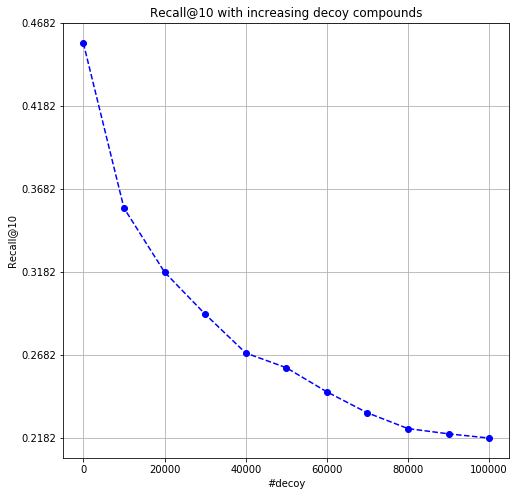

In [92]:
plt.plot(decoy_counts, recalls, linestyle='--', marker='o', color='b')
plt.title('Recall@10 with increasing decoy compounds')
plt.ylabel('Recall@10')
plt.xlabel('#decoy')
plt.grid(b=True, which='both')
plt.yticks(np.arange(min(recalls), max(recalls)+0.05, 0.05))